Autores: ....

# EDA

### Normalización de datos y validación

* Utilizamos info() para revisar la estructura y los tipos de datos del conjunto.
    * Los detalles concretos con shape, columns o dtypes.
* Clasificación de región en Regiones y Ciudades
* Explorar datos, fechas, nulos, columnas innecesarias
* Discusión sobre qué hacer con los datos de semanas que faltan (interpolante)

##### Mostrar la estructura de datos del dataset avocados

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import avocado_manager as av

color_orga ='green'; color_conv ='grey'; color_total ='blue'
av.init()
df_cp = av.df("df_cp")
print(df_cp.info())

df_cp_cleaned = df_cp
df_cp_cleaned['Suma Volums'] = df_cp_cleaned['Volume_Hass_S' ]+ df_cp_cleaned['Volume_Hass_L']+ df_cp_cleaned['Volume_Hass_XL' ]
df_cp_cleaned['Variacio'] = (df_cp_cleaned['Total Volume'] - df_cp_cleaned['Suma Volums'])*100/df_cp_cleaned['Total Volume']
av.add(df_cp_cleaned,'df_cleaned')

region_largest= df_cp.groupby('region')['Total Volume'].sum().nlargest(10).index
av.add(region_largest,'df_region_largest')
smallest_regions= df_cp_cleaned[df_cp_cleaned['region'].isin(region_largest)]
av.add(smallest_regions,'df_smallest_regions')

av.info()
#small_group = df_cp_cleaned.groupby('region')['Variacio'].mean().sort_values()
#small_group

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           18249 non-null  int64         
 1   Date            18249 non-null  datetime64[ns]
 2   AveragePrice    18249 non-null  float64       
 3   Total Volume    18249 non-null  float64       
 4   Volume_Hass_S   18249 non-null  float64       
 5   Volume_Hass_L   18249 non-null  float64       
 6   Volume_Hass_XL  18249 non-null  float64       
 7   Total Bags      18249 non-null  float64       
 8   Small Bags      18249 non-null  float64       
 9   Large Bags      18249 non-null  float64       
 10  XLarge Bags     18249 non-null  float64       
 11  type            18249 non-null  object        
 12  year            18249 non-null  int64         
 13  region          18249 non-null  object        
 14  region_class    18249 non-null  object        
dtypes:

In [ ]:
data_shape = df_cp.shape
print(f"\nForma del DataFrame (filas, columnas): {data_shape}")

column_names = df_cp.columns
print(f"\nNombres de Columnas: {column_names}")
 
data_types = df_cp.dtypes
print(f"\nTipos de datos de cada columna:\n{data_types}")

#df_cp.head()
#df_cp.info()
#df_cp.describe()

##### Nuestra clasifiacion de clases de regiones

In [ ]:
#display(df_cp)
print("Nuestra clasifiacion de clases de regiones:",pd.unique(df_cp['region_class']))
#display(df_cp.head(5))
#display(av.region_classification['GreatRegions'])
g_regions = {key: value for key, value in av.region_classification.items() if value == 'GreaterRegion'}
display(g_regions)
regions = {key: value for key, value in av.region_classification.items() if value == 'Region'}
display(regions)

##### Mostrar las Regions top 10 por Total Volume

In [ ]:
df_totales = df_cp.groupby('region')['Total Volume'].sum().reset_index()
display(df_totales.nlargest(10,'Total Volume').sort_values(by='Total Volume', ascending = False))
#df_largest = av.df("region_largest")
#display(df_largest)

##### Identificar fechas faltantes por cada region

In [ ]:
df_count = df_cp.groupby(['Date', 'region']).size().reset_index(name='Total')
df_pivot = df_count.pivot(index='Date', columns='region', values='Total').fillna(0)
diferencias = df_pivot.apply(lambda x: x.nunique() > 1, axis=0)

regiones_con_diferencias = diferencias[diferencias].index.tolist()
df_pivot[regiones_con_diferencias].plot(kind='line', marker='.',figsize=(10, 3))
plt.title('Número de filas(registros) por Región a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Total de Registros')
plt.legend(title='Regiones:')
plt.grid(); plt.tight_layout() #plt.xticks(rotation=90)
plt.show()

##### Análisis exploratorio para entender la estructura del conjunto, incluyendo el número de filas y columnas, tipos de datos y valores faltantes. 

* Imprime la cantidad de valores faltantes por columna utilizando isnull().

In [ ]:
print(f"Cantidad de nulls: {df_cp.isnull().sum()}")
#df.isnull
#missing_values = pd.isnull(df)

# Resumen Estadístico
data_summary = df_cp.describe()
print("\nResumen Estadístico:")
print(data_summary)

# series de tiempo
print("\nseries de tiempo:")
df_cp['Date'] = pd.to_datetime(df_cp['Date'])
ventas_mensual = df_cp.groupby(df_cp['Date'].dt.to_period("M"))['Total Volume'].sum().reset_index()
display(ventas_mensual)

### Visión global de datos

##### Analisis de Series Temporales y Ruido asociado
Observaciones:

* TODO: Perido de 52 semanas para ver la evolucion a la lo largo de los 3 años ?

In [ ]:
print(f"Ragos de fechas: mínima: {df_cp.Date.min()} máxima: {df_cp.Date.max()}")

df_grouped = df_cp.groupby('Date')['AveragePrice'].mean()
df_cp_conventional = df_cp[df_cp['type'] =='conventional']#[['Date', 'AveragePrice']]
df_grouped = df_cp_conventional.groupby('Date')['AveragePrice'].mean()

# Descomposicio de la serie de tiemps: 39 mesos si considerem que tenim del 1-1-2015 fins al 25-3-2018
df_decomp = seasonal_decompose(df_grouped, model='additive', period=(int)(52*1)) #maxim: 84

plt.figure(figsize=(10, 2))
plt.plot(df_decomp.observed, label='avocado convencional')
plt.legend(loc='best');plt.grid(True)
#plt.title('Tendencia')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(df_decomp.trend, color='red', label='Tendencia mensual(avocado convencional)')
plt.legend(loc='best');plt.grid(True)
#plt.title('Tendencia')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(df_decomp.seasonal, label='Estacionalidad (avocado convencional)')
plt.legend(loc='best');plt.grid(True)
#plt.title('Estacionalidad')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(df_decomp.resid, color='green', label='Residuo (avocado convencional)')
plt.legend(loc='best');plt.grid(True)
#plt.title('Residuo')
plt.tight_layout()
plt.show()

In [ ]:
#print("Organic")
df_grouped = df_cp.groupby('Date')['AveragePrice'].mean()
df_cp_organic = df_cp[df_cp['type'] =='organic']
df_grouped = df_cp_conventional.groupby('Date')['AveragePrice'].mean()
# Descomposicio de la serie de tiemps: 39 mesos si considerem que tenim del 1-1-2015 fins al 25-3-2018
df_decomp = seasonal_decompose(df_grouped, model='additive', period=(int)(52*1)) #maxim: 84
plt.figure(figsize=(10, 8))

plt.subplot(411)
plt.plot(df_grouped, label='avocado Organic')
plt.legend(loc='best');plt.grid(True)
plt.subplot(412)
plt.plot(df_decomp.trend, color='red', label='Tendencia (avocado Organic)')
plt.legend(loc='best');plt.grid(True)
plt.subplot(413)
plt.plot(df_decomp.seasonal,label='Estacionalidad (avocado Organic)')
plt.legend(loc='best');plt.grid(True)
plt.subplot(414)
plt.plot(df_decomp.resid, color='green',label='Residuales (avocado Organic)')
plt.legend(loc='best');plt.grid(True)
plt.tight_layout()
plt.show()

##### Precios promedio calibre

In [ ]:
df_avocado_size = df_cp.copy()
df_avocado_size['Volume_Hass_S ratio'] = df_avocado_size['Volume_Hass_S'] / df_avocado_size['Total Volume']
df_avocado_size['Volume_Hass_L ratio'] = df_avocado_size['Volume_Hass_L'] / df_avocado_size['Total Volume']
df_avocado_size['Volume_Hass_XL ratio'] = df_avocado_size['Volume_Hass_XL'] / df_avocado_size['Total Volume']

In [ ]:
corr_df= df_avocado_size[['AveragePrice', 'Volume_Hass_S ratio', 'Volume_Hass_L ratio', 'Volume_Hass_XL ratio']]
# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación AveragePrice - Calibres')
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

In [ ]:
corr_df= df_cp_cleaned[['Total Volume', 'Volume_Hass_S', 'Volume_Hass_L', 'Volume_Hass_XL']]
# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación Total Volume - Calibres')
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

##### Proporción de calibres sobre Total Volume

In [ ]:
fig, ax= plt.subplots(figsize=(20,8))
ratio_bag=df_avocado_size.groupby('region')[['Volume_Hass_S ratio', 'Volume_Hass_L ratio', 'Volume_Hass_XL ratio']].mean()
ratio_bag.plot(kind='bar', color=['green', 'orange', 'red'],ax=ax )

### Total Bags = Small Bags + Large Bags + XLarge Bags

In [ ]:
bags_df = df_cp_cleaned.copy()
bags_df['Suma Bags'] = bags_df['Small Bags']+ bags_df['Large Bags']+ bags_df['XLarge Bags']
bags_df['Variacio Bags'] = (bags_df['Total Bags'] - bags_df['Suma Bags'])*100/bags_df['Total Bags']
fig, ax= plt.subplots(figsize=(6,3))
bags_df['Variacio Bags'].hist(bins=100)

##### Proporción por tipo de bolsa sobre Total Bags

In [ ]:
df_baggy = df_cp.copy()
region_largest= df_cp.groupby('region')['Total Volume'].sum().nlargest(10).index
df_baggy = df_baggy[df_baggy['region'].isin(region_largest)]

df_baggy['Small Bags ratio'] = df_baggy['Small Bags'] / df_baggy['Total Bags']
df_baggy['Large Bags ratio'] = df_baggy['Large Bags'] / df_baggy['Total Bags']
df_baggy['XLarge Bags ratio'] = df_baggy['XLarge Bags'] / df_baggy['Total Bags']

fig, ax= plt.subplots(figsize=(12,3))
ratio_bag=df_baggy.groupby('region')[['Small Bags ratio','Large Bags ratio', 'XLarge Bags ratio']].mean()
ratio_bag.plot(kind='bar', color=['green', 'orange', 'red'],ax=ax )

In [ ]:
corr_df= df_baggy[['AveragePrice', 'Small Bags', 'Large Bags', 'XLarge Bags']]
# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación (nlargest(10))')
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

In [ ]:
df_baggy = df_cp.copy()
region_largest= df_cp.groupby('region')['Total Volume'].sum().nlargest(10).index
df_baggy = df_baggy[df_baggy['region'].isin(region_largest)]

df_baggy['Small Bags ratio'] = df_baggy['Small Bags'] / df_baggy['Total Bags']
df_baggy['Large Bags ratio'] = df_baggy['Large Bags'] / df_baggy['Total Bags']
df_baggy['XLarge Bags ratio'] = df_baggy['XLarge Bags'] / df_baggy['Total Bags']

df_baggy=df_baggy[df_baggy['region']=='LosAngeles']

corr_df= df_baggy[['AveragePrice', 'Small Bags', 'Large Bags', 'XLarge Bags']]
# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación (LosAngeles)')
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

##### Precio medio y volumen total
Observaciones:
* TODO: Estamos mostrado los de tipo convencional. Que son los grupos de puntos de la parte superior ? TotalUS y Grandes Regions.

In [ ]:
df_cp_tmp = df_cp[df_cp['type']=='conventional']

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].scatter(df_cp_tmp['AveragePrice'], df_cp_tmp['Total Volume'], alpha=0.5)
ax[0].set_title('Relación entre Precio medio y volumen total de no organicos')
ax[0].set_xlabel('Averag ePrice')
ax[0].set_ylabel('Total Volume')
ax[0].grid()

ax[1].scatter(df_cp_tmp['AveragePrice'], df_cp_tmp['Total Volume'], alpha=0.5)
ax[1].set_title('Relación entre Precio medio y volumen total de no organicos (Log)')
ax[1].set_xlabel('Averag ePrice')
ax[1].set_ylabel('Total Volume')
ax[1].grid()
ax[1].set_yscale('log')

plt.tight_layout()
# df_cp.groupby(by=['region']).count()

##### Separar avocados convencional y organics
Observaciones:
* TODO: Aqui es veu clarament que el alvocat més relevant es el convencional per ordres de magnitud, per ho que seria relevant fer algún estudi del subset eliminant els organics o estudian-los per separat.
* Addicionalment, l'any 2018 no esta complert, pot afectar a les dades.

In [ ]:
grouped = df_cp.groupby(['year', 'type'])['Total Volume'].sum()
fig, ax= plt.subplots(figsize=(12,3))
grouped.plot(kind='bar', color=[color_conv, color_orga])
plt.xlabel('Año y tipo')
plt.ylabel('Total Volume')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
df_grouped = df_cp.groupby('Date')['AveragePrice'].mean()

plt.figure(figsize=(12, 3))
plt.plot(df_grouped, label ='Precio Medio')
plt.legend(loc='best')
plt.xlabel('Tiempo')
plt.ylabel('Precio medio')
plt.title('Precio medio en el tiempo')
plt.grid(True); plt.xticks(rotation=0)
plt.show()

df_grouped = df_cp.groupby(pd.Grouper(key='Date', freq='M'))['AveragePrice'].mean()
plt.figure(figsize=(12,3))
plt.plot(df_grouped, label='Precio medio mensual') #plt.plot(df_grouped.index, df_grouped.values)
plt.legend(loc='best')
plt.xlabel('Fecha')
plt.ylabel('Precio medio')
plt.title('Precio medio mensual')
plt.grid(True); plt.xticks(rotation=0)
plt.show()

df_cp_conventional = df_cp[df_cp['type'] =='conventional'] #[['Date', 'AveragePrice']]
df_grouped_conv = df_cp_conventional.groupby('Date')['AveragePrice'].mean()

df_cp_organic = df_cp[df_cp['type'] =='organic'] #[['Date', 'AveragePrice']]
df_grouped_orga = df_cp_organic.groupby('Date')['AveragePrice'].mean()

plt.figure(figsize=(12, 3))
plt.plot(df_grouped_conv, label ='Precio Medio convencional', color ='grey')
plt.plot(df_grouped_orga, label ='Precio Medio organic', color ='green')
plt.legend(loc='best')
plt.xlabel('Tiempo')
plt.ylabel('Precio medio')
plt.title('Precio medio en el tiempo segun tipo alvocado')
plt.grid(True); plt.xticks(rotation=0)
plt.show()

#df_grouped

##### Comparación precios promedio convencional y organico
Observaciones:
* TODO: Aqui veiem que existeixen unes regions mes relevants que altres. Caldria fer una separació?
* TODO: Excloure TotalUS ??

In [ ]:
df_subset = df_cp
#df_subset = df_cp[df_cp['region']!= 'TotalUS']
pd.unique(df_subset['region'])

grouped = df_subset.groupby(['region', 'type'])['Total Volume'].sum()

fig, ax= plt.subplots(figsize=(20,4))
grouped.plot(kind='bar', ax=ax, color = [color_conv, color_orga] )
# plt.ylim(0, 0.3*10**9)
plt.grid()

In [ ]:
price_group = df_subset.groupby(['region', 'type'])['AveragePrice'].mean()#.nlargest(10)

fig, ax= plt.subplots(figsize=(20,4))
price_group.plot(kind='bar', ax=ax, color = [color_conv, color_orga] )
# plt.ylim(0, 0.3*10**9)
plt.grid()

Observaciones:
* TODO: Aquest gràfic es espectacular, y ens permet veure que sempre són els alvocats orgànics els que costen més que la mitjana.

In [ ]:
df_subset = df_cp
avocados_region_mean = df_subset.groupby(['region','type'])['AveragePrice'].mean()#.nlargest(6)

total_mean = df_subset['AveragePrice'].mean()
fig, ax= plt.subplots(figsize=(20,4))
avocados_relative_mean = (avocados_region_mean - total_mean)*100/total_mean
avocados_relative_mean.plot(kind = 'bar', ylabel= '% Price deviation', color = [color_conv, color_orga]) # 'slategray', 'forestgreen'])
plt.grid()

##### TODO: Convencional vs Organic
Observaciones:
* TODO: 
  * Si mirem la proporcio, en general es manté constant. No hi ha ningun interes per a tornar a ho natural a les gran ciutats o extensions.
  * Si acas hi ha més divergencia en extensions menors.

In [ ]:
grouped = df_subset.groupby(['region', 'type'])['Total Volume'].sum()
unstacked_type= grouped.unstack()
unstacked_type['Proportion'] = unstacked_type['conventional']/unstacked_type['organic']

fig, ax= plt.subplots(figsize=(12,4))
x_values= unstacked_type['conventional']
y_values= unstacked_type['Proportion']
ax.scatter(x=x_values, y= y_values )
# plt.ylim(0, 0.3*10**9)
plt.grid()

##### Ventas en el tiempo y separación entre convencional / orgánico

In [ ]:
df_date_volume = df_cp[['Date', 'Total Volume']]
#df_cp_organic = df_cp[df_cp['type'] =='organic'] #[['Date', 'AveragePrice']]
#df_date_volume
df_grouped_conventional = df_date_volume[df_cp['type'] =='conventional'].groupby('Date').sum('Total Volume')
df_grouped_organic = df_date_volume[df_cp['type'] =='organic'].groupby('Date').sum('Total Volume')

# Graficar
plt.figure(figsize=(12,3))
plt.title('Volumen total de ventas a lo targo del tiempo')
plt.plot(df_grouped_conventional, label='Volumen total ventas (conventional)')
plt.xlabel('Fecha')
plt.ylabel('Volumen ventas')
plt.legend(loc='best'); plt.grid(True)
plt.plot(df_grouped_organic, label='Volumen total ventas (organic)')
plt.xlabel('Fecha')
plt.ylabel('Volumen ventas')
plt.legend(loc='best'); plt.grid(True)
plt.show()

plt.figure(figsize=(12,3))
plt.title('Volumen total de ventas a lo targo del tiempo - escala logaritmica')
plt.plot(df_grouped_conventional, label='Volumen total ventas (conventional) escala logaritmica')
plt.xlabel('Fecha')
plt.ylabel('Volumen ventas')
plt.yscale('log')
plt.legend(loc='best'); plt.grid(True)
plt.plot(df_grouped_organic, label='Volumen total ventas (organic) escala logaritmica')
plt.xlabel('Fecha')
plt.ylabel('Volumen ventas')
plt.yscale('log')
plt.legend(loc='best'); plt.grid(True)
plt.show()

##### Análisis de Cambios en Precios Anuales:

In [ ]:
df_year_price = df_cp.groupby('year')['AveragePrice'].mean()
df_year_price_conventional = df_cp[df_cp['type'] =='conventional'].groupby('year')['AveragePrice'].mean()
df_year_price_organic = df_cp[df_cp['type'] =='organic'].groupby('year')['AveragePrice'].mean()
display(df_year_price)

# Graficar
plt.figure(figsize=(10, 2)) 
df_year_price.plot.bar(label ='Precio medio', color = color_total, alpha=1) # x='aaa??',y='bbb??',
plt.xlabel('Año')
plt.ylabel('Precio medio')
plt.title('Precio medio anual')
plt.legend(loc='lower right'); plt.grid(True)
plt.xticks(rotation=0)
plt.show()


plt.figure(figsize=(10, 2)) 
df_year_price_organic.plot.bar(label ='Precio medio alvocado organic', color = color_orga) # x='aaa??',y='bbb??',
df_year_price_conventional.plot.bar(label ='Precio medio alvocado conventional', color = color_conv) # x='aaa??',y='bbb??',
#df_year_price.plot.bar(label ='Precio medio', color ='blue', alpha=0.2) # x='aaa??',y='bbb??',
plt.xlabel('Año')
plt.ylabel('Precio medio')
plt.title('Precio medio anual')
plt.legend(loc='lower right'); plt.grid(True)
plt.xticks(rotation=0)
plt.show()

##### Representación de ventas totales sobre precio promedio ( por regiones o no )

In [ ]:
classification_colors = {'City':'green' ,'Region':'red' ,'GreaterRegion':'orange', 'TotalUS': 'blue'}

df_subset = df_cp.copy()
#df_subset = av.df("df_city_region") 
#df_subset = df_cp[df_cp['region']!= 'TotalUS']

df_organic = df_subset[df_subset['type']=='organic']
df_convencionals = df_subset[df_subset['type']=='conventional']

fig, ax= plt.subplots(figsize=(12,4))
x_values = df_convencionals['Total Volume']
y_values = df_convencionals['AveragePrice']
c_values= list(df_convencionals['region_class'].map(classification_colors))
plt.scatter(x= x_values, y= y_values, c=c_values, alpha = .5)
plt.title('Tipo convencionales (log)')
plt.xscale('log')
plt.ylabel('Average price')
plt.xlabel('Market size')
legend_patches = [mpatches.Patch(color=color, label=region) for region, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='upper right')
plt.grid()

fig, ax= plt.subplots(figsize=(12,4))
x_values = df_organic['Total Volume']
y_values = df_organic['AveragePrice']
c_values= list(df_organic['region_class'].map(classification_colors))
plt.scatter(x= x_values, y= y_values, c=c_values, alpha = .5)
plt.title('Tipo organicos (log)')
plt.xscale('log')
plt.ylabel('Average price')
plt.xlabel('Market size')
legend_patches = [mpatches.Patch(color=color, label=region) for region, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='upper right')
plt.grid()

In [ ]:
df_subset = df_cp[df_cp['region']!= 'TotalUS']
df_organic = df_subset[df_subset['type']=='organic']
df_convencionals = df_subset[df_subset['type']=='conventional']

# df_convencionals
index_df = df_cp_cleaned.copy()
#['West', 'California', 'SouthCentral', 'Northeast', 'Southeast']
great_reg_col = {'California' : 'red', 'West':'Orange', 'SouthCentral':'green', 'Northeast':'SkyBlue', 'Southeast':'DarkBlue'}

region_largest= list(index_df.groupby('region')['Total Volume'].sum().nlargest(5).index)
df_regions = df_convencionals[df_convencionals['region'].isin(region_largest)]

In [ ]:
fig, ax= plt.subplots(figsize=(16,4))
y_values = df_regions['Total Volume']
x_values = df_regions['Date']
c_values= list(df_regions['region'].map(great_reg_col))

plt.scatter(x= x_values, y= y_values, c=c_values, alpha = 1)
plt.yscale('log')
plt.title('Total Volume en el tiempo (log)')
plt.ylabel('Total Volume')
#plt.xlabel('Date')
#plt.legend() #loc='lower right')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=region, markerfacecolor=color, markersize=8) for region, color in great_reg_col.items() if region in df_regions['region'].unique()]
plt.legend(handles=legend_handles, loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.grid()

* Nota: Aquí los outlayers también parecen corresponden con las fechas de la Super Bowl.

In [ ]:
fig, ax= plt.subplots(figsize=(16,4))
y_values = df_regions['AveragePrice']
x_values = df_regions['Date']
c_values= list(df_regions['region'].map(great_reg_col))

plt.scatter(x= x_values, y= y_values, c=c_values, alpha = 1)
#plt.yscale('log')
plt.title('Precio medio en el tiempo')
plt.ylabel('AveragePrice')
#plt.xlabel('Date')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=region, markerfacecolor=color, markersize=8) for region, color in great_reg_col.items() if region in df_regions['region'].unique()]
plt.legend(handles=legend_handles, loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.grid()

### Subset alvocados convencionals
* Aqui tendriamos que incluir una idea de si todas las regiones hacen un número similar total de pedidos
* Claramente hay sitios donde los aguacates son más baratos, miremos si tiene que ver con otras características

In [ ]:
df_subset = df_cp[df_cp['region']!= 'TotalUS']
df_convencionals = df_subset[df_subset['type']=='conventional']
convencional_region_mean = df_convencionals.groupby('region')['AveragePrice'].mean()#.nlargest(6)
coloring=convencional_region_mean.index.map(av.region_classification).map(av.classification_colors)
total_mean = df_convencionals['AveragePrice'].mean()
fig, ax= plt.subplots(figsize=(20,4))
avocados_relative_mean = ((convencional_region_mean - total_mean)*100/total_mean)
avocados_relative_mean.plot(kind = 'bar', ylabel= '% Price deviation')#, color= coloring)#, color= convencional_region_mean.index.map(classification_colors))
plt.grid()

* TODO 

In [ ]:
convencional_region_mean_total = df_convencionals.groupby('region').agg({'Total Volume':'mean', 'AveragePrice':'mean'})#.nlargest(6)
convencional_region_mean_total['region_class'] = convencional_region_mean_total.index.map(av.region_classification)
classification_colors = {'City':'green' ,'Region':'yellow' ,'GreaterRegion':'orange', 'State':'red'}
fig, ax= plt.subplots(figsize=(20,4))
x_values = convencional_region_mean_total['Total Volume']
total_mean = df_convencionals['AveragePrice'].mean()
y_values = (convencional_region_mean_total['AveragePrice'] - total_mean)*100/total_mean
c_values= convencional_region_mean_total['region_class'].map(classification_colors)

plt.scatter(x= x_values, y= y_values)
plt.ylabel('% Average price deviation')
plt.xlabel('Market size')
plt.grid()

### Majors mercats el preu mig tendeix a abaratirse
* Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
* Aqui estem prenent cada regio com equivalentment valida
* cambiar el 2018 no parece afectar los resultados

In [ ]:
convencional_region_mean_total = df_convencionals.groupby('region').agg({'Total Volume':'sum', 'AveragePrice':'mean'})#.nlargest(6)
convencional_region_mean_total['region_class'] = convencional_region_mean_total.index.map(av.region_classification)

x_values = convencional_region_mean_total['Total Volume']
total_mean = convencional_region_mean_total['AveragePrice'].mean()
y_values = (convencional_region_mean_total['AveragePrice'] - total_mean)*100/total_mean
c_values= list(convencional_region_mean_total['region_class'].map(av.classification_colors))

fig, ax= plt.subplots(figsize=(12,6))
plt.scatter(x= x_values, y= y_values, c=c_values)
plt.xscale('log')
plt.ylabel('% Average price deviation')
plt.xlabel('Market size')
legend_patches = [mpatches.Patch(color=color, label=region) for region, color in av.classification_colors.items()]
plt.legend(handles=legend_patches, loc='best', bbox_to_anchor=(1, 1), ncol=1)
plt.grid()

In [ ]:
df_cp_cleaned = df_cp[df_cp['region_class'] !='TotalUS'].copy()
convencional_region_mean_total = df_cp_cleaned.groupby(['region','type']).agg({'Total Volume':'sum', 'AveragePrice':'mean'})#.nlargest(6)

for region in pd.unique(df_cp_cleaned['region']):
    convencional_region_mean_total.loc[(region, 'organic'),'Total Volume'] = convencional_region_mean_total.loc[(region, 'conventional'),'Total Volume']

new_convencional_region_mean_total= convencional_region_mean_total.reset_index(level='type') 
type_coloring= {'organic':color_orga, 'conventional':color_conv}

fig, ax= plt.subplots(figsize=(20,4))
x_values = new_convencional_region_mean_total['Total Volume']
total_mean = new_convencional_region_mean_total['AveragePrice'].mean()
y_values = (new_convencional_region_mean_total['AveragePrice'] - total_mean)*100/total_mean
c_values= new_convencional_region_mean_total['type'].map(type_coloring)

plt.scatter(x= x_values, y= y_values, c=c_values)
plt.ylabel('% Average price deviation')
plt.xlabel('Market size')
plt.grid()

# ANALISIS

#### Boxplot Comparativo de Precios entre Años

In [ ]:
df_cp_conventional = df_cp[df_cp['type'] =='conventional'] #[['Date', 'AveragePrice']]
sns.set_style('whitegrid')
plt.figure(figsize=(12,4))
sns.boxplot(df_cp_conventional, x="year", y="AveragePrice", fill=False, gap=.5, color = color_conv)
plt.title("Average Price por año - alvocado: Convencional")#,{'fontsize':20})
plt.xlabel('Año')#,{'fontsize' : 'large'})
plt.ylabel('Precio medio')#,{'fontsize':'large'})
plt.show()

df_cp_cleaned = df_cp[df_cp['region_class'] !='TotalUS'].copy()
plt.figure(figsize=(12,4))
sns.boxplot(df_cp_cleaned, x="year", y="AveragePrice", hue='type', fill=False, gap=0.5)
plt.title("Average Price por año y tipo") #,{'fontsize':40})
plt.xlabel('Año') #,{'fontsize' : 30})
plt.ylabel('Precio medio') #,{'fontsize':'large'})
plt.show()
sns.reset_defaults()

In [ ]:
df_cp = av.df("df_cp")
df_cp_organic = df_cp[df_cp['type'] =='organic']
#regiones = ['West', 'California']
regiones = av.Manager.obtener_regions('GreaterRegion')
df_filtrado = df_cp_organic[df_cp_organic['region'].isin(regiones)]

plt.figure(figsize=(20,4))
sns.boxplot(df_filtrado, x="year", y="AveragePrice", hue="region", dodge=True, fill=False, gap=.2)
plt.title("Average Price Organico por año y region",{'fontsize':20})
plt.xlabel('Año')#,{'fontsize' : 'large'})
plt.ylabel('Region')#,{'fontsize':'large'})
plt.legend(loc='best') #, bbox_to_anchor=(1, 1), ncol=1)
plt.show()

#### Histograma de Volumen Total de Ventas

In [ ]:
df_cp_cleaned=df_cp[df_cp.region != 'TotalUS']

sns.set_style('whitegrid')
plt.figure(figsize=(20,6))
plt.xlim(0.0,0.6*10**7)
plt.ylim(0.0,2*10**-6)
plt.title('Histograma de Ventas Totales', fontweight = "bold")
plt.hist(df_cp_cleaned['Total Volume'], bins= 200, density=0.5, color='green',alpha=0.9)
plt.xlabel('Ventas')
plt.ylabel('Frecuencia')
plt.show()
sns.reset_defaults()

#### Precios Promedios por Año

In [ ]:
y=df_cp.groupby(['year'])['AveragePrice'].mean()
x=(df_cp['year'].unique())
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title('Precios Promedios por Año')
plt.grid()
plt.show()

#### Separar alvocados convencionales y organicos

In [ ]:
df_cp = av.df("df_cp")
average_prices = df_cp['AveragePrice']
print(f"AveragePrice: min: {df_cp['AveragePrice'].min()} max: {df_cp['AveragePrice'].max()}")

plt.figure(figsize=(10, 6))
sns.histplot(average_prices, bins=100, kde=True, color='skyblue')
plt.title('Histogram of Average Avocado Prices')
plt.xlabel('Average Price')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [ ]:
df_cp = av.df("df_cp")
average_price_by_type = df_cp.groupby('type')['AveragePrice'].mean()
print(average_price_by_type)

plt.figure(figsize=(10, 6))
plt.hist(
    [df_cp_cleaned[df_cp_cleaned['type'] == 'conventional']['AveragePrice'], 
     df_cp_cleaned[df_cp_cleaned['type'] == 'organic']['AveragePrice']],
    bins=100, label=['Conventional', 'Organic'], alpha=0.9
)

# Add titles and labels
plt.title("Histogram of Average Avocado Prices by Type")
plt.xlabel("Average Price")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [ ]:
df_cp_cleaned = df_cp.copy()
df_cp_cleaned = df_cp[df_cp.region == 'TotalUS'].copy() 
region_largest= df_cp_cleaned.groupby('type')['Total Volume'].sum().nlargest(2).index
transparencia = .5
plt.figure(figsize=(10, 6))
for type in region_largest:
    df_cp_temp = df_cp_cleaned[df_cp_cleaned['type'] ==type]
    ax = df_cp_temp['AveragePrice'].hist(bins=50, label=str(type), alpha = transparencia)    
    #sns.kdeplot(df_cp_temp['AveragePrice'], ax=ax, label=str(type))
    transparencia += .3    
plt.title('Distribución del precio medio según tipo de alvocado - TotalUS')
plt.xlabel('Average Price')
plt.ylabel('Frecuencia')
plt.legend(loc='best')
plt.show()

df_cp_cleaned = df_cp.copy()
df_cp_cleaned = df_cp[df_cp.region != 'TotalUS'].copy() 
region_largest= df_cp_cleaned.groupby('type')['Total Volume'].sum().nlargest(2).index

transparencia = .5
plt.figure(figsize=(10, 6))
for type in region_largest:
    df_cp_temp = df_cp_cleaned[df_cp_cleaned['type'] ==type]
    ax = df_cp_temp['AveragePrice'].hist(bins=50, label=str(type), alpha = transparencia)    
    #sns.kdeplot(df_cp_temp['AveragePrice'], ax=ax, label=str(type))
    transparencia += .3
plt.title('Distribución del precio medio según tipo de alvocado excluido TotalUS')
plt.xlabel('Average Price')
plt.ylabel('Frecuencia')
plt.legend(loc='best')
plt.show()


#### Ventas por Tipo de Bolsa

In [ ]:
tipos_bolsas=['Total Bags','Small Bags','Large Bags','XLarge Bags']
ventas=[df_cp['Total Bags'].sum(),df_cp['Small Bags'].sum(),df_cp['Large Bags'].sum(),df_cp['XLarge Bags'].sum()]

plt.figure(figsize=(10, 6))
plt.title('Grafico de Barras por Tipo de Bolsa', fontweight = "bold")
plt.xlabel("Tipo de Bolsa")
plt.ylabel("Ventas")
plt.grid()
plt.bar(tipos_bolsas,ventas, color = color_total, width=0.4)

In [ ]:
df_cp_organic = av.df("df_cp_organic")
ventas_org=[df_cp_organic['Total Bags'].sum(),df_cp_organic['Small Bags'].sum(),df_cp_organic['Large Bags'].sum(),df_cp_organic['XLarge Bags'].sum()]
plt.figure(figsize=(10, 6))
plt.title('Grafico de Barras por Tipo de Bolsa Organica', fontweight = "bold")
plt.xlabel("Tipo de Bolsa")
plt.ylabel("Ventas")
plt.bar(tipos_bolsas,ventas_org, color = color_orga, width=0.4)
plt.show()

df_cp_conventional = av.df("df_cp_conventional")
ventas_conv=[df_cp_conventional['Total Bags'].sum(),df_cp_conventional['Small Bags'].sum(),df_cp_conventional['Large Bags'].sum(),df_cp_conventional['XLarge Bags'].sum()]
plt.figure(figsize=(10, 6))
plt.title('Grafico de Barras por Tipo de Bolsa Convencional', fontweight = "bold")
plt.xlabel("Tipo de Bolsa")
plt.ylabel("Ventas")
plt.bar(tipos_bolsas,ventas_conv, color = color_conv, width=0.4)
plt.show()

In [ ]:
df_cp_organic = av.df("df_cp_organic")
df_cp_conventional = av.df("df_cp_conventional")

ventas_org=[df_cp_organic['Total Bags'].sum(),df_cp_organic['Small Bags'].sum(),df_cp_organic['Large Bags'].sum(),df_cp_organic['XLarge Bags'].sum()]
ventas_conv=[df_cp_conventional['Total Bags'].sum(),df_cp_conventional['Small Bags'].sum(),df_cp_conventional['Large Bags'].sum(),df_cp_conventional['XLarge Bags'].sum()]

x = np.arange(len(tipos_bolsas))  # Posición de cada tipo de bolsa
width = 0.35
plt.figure(figsize=(10, 6))
plt.bar(x + width/2, ventas_org, width, label='Orgánico', color= color_orga)
plt.bar(x - width/2, ventas_conv, width, label='Convencional', color= color_conv)
plt.title('Ventas por Tipo de Bolsa: Orgánica vs Convencional', fontweight="bold")
plt.xlabel("Tipo de Bolsa")
plt.ylabel("Ventas")
plt.xticks(x, tipos_bolsas)  # Posicionar etiquetas en el centro de los grupos de barras
plt.legend()
plt.show()

#### Total Volume respecto al conjunto de volumenes por calibres de HASS S, L y XL

In [ ]:
# Para seleccionar unicamente las regiones propias , descartamos Total US para la vista gráfica
df_cp_cleaned = df_cp[df_cp.region != 'TotalUS'].copy() 
df_cp_cleaned['Suma Volums'] = df_cp_cleaned['Volume_Hass_S'] + df_cp_cleaned['Volume_Hass_L'] + df_cp_cleaned['Volume_Hass_XL']
df_cp_cleaned['Variacio'] = (df_cp_cleaned['Total Volume'] - df_cp_cleaned['Suma Volums']) *100 /df_cp_cleaned['Total Volume']
# df_cp_cleaned_city = df_cp_cleaned[df_cp_cleaned['region_class']=='City']
region_largest= df_cp_cleaned.groupby('region')['Total Volume'].sum().nlargest(5).index

plt.figure(figsize=(10, 6))
transparencia = 1
for region in region_largest:#, 'TotalUS']:#.nlargest(6)
    df_cp_temp = df_cp_cleaned[df_cp_cleaned['region'] ==region]
    df_cp_temp['Variacio'].hist(bins=50, label=str(region), alpha = transparencia)
    plt.title('Distribución del % variación Total Volume respecto als conjunto de calibres')
    plt.xlabel('% variación')
    plt.ylabel('Frecuencia')
    plt.legend(loc='best')
    transparencia-=0.2
plt.show()

plt.figure(figsize=(10, 6))
transparencia = 1
for region in ['LosAngeles', 'NewYork', 'Houston']:#, 'TotalUS']:#.nlargest(6)
    df_cp_temp = df_cp_cleaned[df_cp_cleaned['region'] ==region]
    df_cp_temp['Variacio'].hist(bins=50, label=str(region), alpha = transparencia)
    plt.title('Distribución del % variación Total Volume respecto als conjunto de calibres')
    plt.xlabel('% variación')
    plt.ylabel('Frecuencia')
    plt.legend(loc='best')
    transparencia-=0.3
plt.show()

#### Impacto del precio en las ventas
* TODO: Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
* Aqui estem prenent cada regio com equivalentment valida  cambiar el 2018 no parece afectar los resultados

In [ ]:
convencional_df = df_cp_cleaned[df_cp_cleaned['type']=='conventional']
organic_df = df_cp_cleaned[df_cp_cleaned['type']=='organic']

convencional_region_mean_total = convencional_df.groupby('region').agg({'Total Volume':'sum', 'AveragePrice':'mean'})#.nlargest(6)
organic_region_mean_total = organic_df.groupby('region').agg({'AveragePrice':'mean'})#.nlargest(6)

convencional_region_mean_total['Price difference'] = organic_region_mean_total['AveragePrice'] - convencional_region_mean_total['AveragePrice'] 

# display(new_df)
fig, ax= plt.subplots(figsize=(20,4))
x_values = convencional_region_mean_total['Total Volume']
# total_mean = new_convencional_region_mean_total['AveragePrice'].mean()
y_values = convencional_region_mean_total['Price difference'] #(new_convencional_region_mean_total['AveragePrice'] - total_mean)*100/total_mean
# c_values= convencional_region_mean_total['type'].map(type_coloring)

plt.scatter(x= x_values, y= y_values)#, c=c_values)
plt.ylabel('Price difference organic vs conventional')
plt.xlabel('Market size')
plt.grid()

#### Estacionalidad por región
* Se observa que en general el precio es más alto en verano y otoño.

In [ ]:
get_season = av.get_season()
df_date_price_volume = df_cp.copy()
df_date_price_volume = df_date_price_volume[df_date_price_volume['region'] != 'TotalUS']
df_date_price_volume = df_date_price_volume[['Date', 'region', 'AveragePrice', 'Total Volume']]
df_date_price_volume['Season'] = df_date_price_volume['Date'].apply(get_season)

df_grouped_mean = df_date_price_volume.groupby(['Season','region'])['AveragePrice'].mean()
df_grouped_mean = df_grouped_mean.reset_index()

seasons = df_grouped_mean['Season'].unique()
plt.figure(figsize=(20, 8)) 
for season in seasons:
    df_season = df_grouped_mean[df_grouped_mean['Season'] == season]
    plt.plot(df_season['region'], df_season['AveragePrice'], marker='.', label=season)
plt.title('Precio medio por temporada y región')
plt.xlabel('Región')
plt.ylabel('Precio medio')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#df_grouped_mean

#### Correlación volumen total entre las "grandes regiones" y "regiones" con total US
* TODO: IMPORTANT VOLUM VENTAS GREATERREGIONS == TOTALUS

In [ ]:
df_great_regions = df_cp[(df_cp['region_class']=='Region') | (df_cp['region_class']=='City')]
df_USA = df_cp[df_cp['region']=='TotalUS']
print((df_great_regions['Total Volume'].sum() - df_USA['Total Volume'].sum())*100/df_USA['Total Volume'].sum() )

In [ ]:
index_df= df_cp.copy()
index_df= index_df[index_df['region_class']=='City']

region_largest= list(index_df.groupby('region')['Total Volume'].sum().nlargest(3).index)
# region_largest.pop('TotalUS')

df_greatest_pie = df_cp.groupby('region')['Total Volume'].sum().nlargest(8)   #df_cp[df_cp['region'].isin(region_largest)]
df_greatest_pie.loc['TotalUS'] = 2*df_greatest_pie.loc['TotalUS'] - df_greatest_pie.loc[:].sum()
df_greatest_pie.rename( index={'TotalUS':'Plains'}, inplace=True)
df_greatest_pie.plot.pie(title="Market size", legend=False, \
                   autopct='%1.1f%%', \
                   shadow=True, startangle=0)
#plt.legend(loc='best'); plt.grid(True) # figsize=(12,6)

### Correlación de Volumen Total de las ciudades con Volumen de Total US (alvocado conventional)

In [ ]:
prova_= df_cp.copy()
index_df= df_cp.copy()
prova_= prova_[prova_['type']=='conventional']
dictionary_to_regions={}

index_df= index_df[index_df['region_class']=='GreaterRegion']
region_largest= list(index_df.groupby('region')['Total Volume'].sum().nlargest(5).index)
region_largest.append('TotalUS')

for region in region_largest:
    prova_temp = prova_[prova_['region']==region]
    prova_temp=prova_temp.sort_values(by='Date')

    dictionary_to_regions[region] = list(prova_temp['Total Bags'])

df_corr = pd.DataFrame(dictionary_to_regions)
# display(df_corr)
corr_matrix = df_corr.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.9
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

##### Fechas con explosión de ventas
* TODO: Super Bowl
  * 2015: 2 de febrero
  * 2016: 7 de febrero
  * 2017: 6 de febrero
  * 2018: 5 de febrero

In [ ]:
prova_= df_cp.copy()
index_df= df_cp.copy()
prova_= prova_[prova_['type']=='conventional']

index_df= index_df[index_df['region_class']=='GreaterRegion']
region_largest= list(index_df.groupby('region')['Total Volume'].sum().nlargest(5).index)
# region_largest.append('TotalUS')

fig, ax= plt.subplots(figsize=(20,4))
for region in region_largest:
    prova_temp = prova_[prova_['region']==region]
    prova_temp=prova_temp.sort_values(by='Date')
    prova_temp.plot(x= 'Date', y= 'Total Volume', ax=ax, label= region)
plt.legend(loc='best'); plt.grid(True)
plt.show()

##### TODO

In [ ]:
#df_cp_cleaned = av.df("df_cleaned")
prova_= df_cp.copy()
index_df= df_cp.copy()
prova_= prova_[prova_['type']=='conventional']

#great_dates= df_cp_cleaned.copy()
#great_dates= great_dates[great_dates['type']=='conventional']

index_df= df_cp.copy()
index_df= index_df[index_df['region_class']=='GreaterRegion']

region_largest= list(index_df.groupby('region')['Total Volume'].sum().nlargest(5).index)
#region_largest#.append('TotalUS')
fig, ax= plt.subplots(figsize=(20,6))
for region in region_largest:
    prova_temp = prova_[prova_['region']==region]
    prova_temp=prova_temp.sort_values(by='Date')
    prova_temp.plot(x= 'Date', y= 'AveragePrice', ax=ax, label= region)

plt.grid()
plt.show()

### Elasticidad

#### Further studies

* Els apartats anteriors han mostrat tendencies claras, pero encara aixi es complicat separar els efectes de convergencia de múltiples variables. Es per això que tractarem de fer subsets per a veure els efectes mes clars.
* Addicionalment tractarem de fer els càlculs d'elasticitat un cop fetes les separacions en el df

#### 2.1. Elasticidad Sobre el tiempo (Conventional USA)

In [ ]:
# Creacion de la variable elasticidad y eliminacion de valores no utiles
df_cp_elast = df_cp.copy()

# Sort by year, asi la elasticidad se calcula entre los valores del mismo grupo
df_sort = df_cp_elast.sort_values(by=['region','type', 'year'])

df_USA = df_sort[df_sort['region']=='TotalUS']

df_USA_conv = df_USA[df_USA['type']=='conventional'].copy()
df_USA_conv['Elasticity'] = df_USA_conv['Total Volume'].pct_change() /  df_USA_conv['AveragePrice'].pct_change()
df_USA_conv =df_USA_conv[-df_USA_conv['Elasticity'].isin([-np.inf,np.inf])]

df_USA_organic = df_USA[df_USA['type']=='organic'].copy()
df_USA_organic['Elasticity'] = df_USA_organic['Total Volume'].pct_change() /  df_USA_organic['AveragePrice'].pct_change()
df_USA_organic =df_USA_organic[-df_USA_organic['Elasticity'].isin([-np.inf,np.inf])]

In [ ]:
# Creem el group by adient
USA_conv_year = df_USA_conv.loc[1:,:].groupby("Date").agg({'Elasticity':"mean"})
USA_org_year = df_USA_organic.loc[1:,:].groupby("Date").agg({'Elasticity':"mean"})

#Plotejem
fig, ax = plt.subplots()
USA_conv_year.loc[:,'Elasticity'].plot(kind = 'line',ax= ax, label= 'Conventional USA', color = 'orange' )
USA_org_year.loc[:,'Elasticity'].plot(kind = 'line',ax= ax, label= 'Organic USA', color = 'green' )
# ax.set_xticks(USA_conv_year.index)
ax.grid()
plt.legend()
plt.ylim(-15,15)
plt.title('Sorted year elasticity')

In [ ]:
# Creem el group by adient
df_USA_temp = df_USA.copy()
df_USA_temp['Elasticity'] = df_USA_temp['Total Volume'].pct_change() /  df_USA_temp['AveragePrice'].pct_change()
df_USA_temp =df_USA_temp[-df_USA_temp['Elasticity'].isin([-np.inf,np.inf])]

type_elasticity_sort = df_USA_temp.loc[1:,:].groupby("type").agg({'Elasticity':"mean"})

type_elasticity_sort

#Plotejem
fig, ax = plt.subplots()
type_elasticity_sort.loc[:,'Elasticity'].plot(kind = 'bar',ax= ax, color = ['gray','green'])
# ax.set_xticks(region_elasticity_sort.index)
ax.grid()
plt.title('Sorted type elasticity')

In [ ]:
# Creem el group by adient
USA_conv_year = df_USA_conv.loc[1:,:].groupby("year").agg({'Elasticity':"mean"})
USA_org_year = df_USA_organic.loc[1:,:].groupby("year").agg({'Elasticity':"mean"})

#Plotejem
fig, ax = plt.subplots()
USA_conv_year.loc[:,'Elasticity'].plot(kind = 'line',ax= ax, label= 'Conventional USA', color = 'orange' )
USA_org_year.loc[:,'Elasticity'].plot(kind = 'line',ax= ax, label= 'Organic USA', color = 'green' )
ax.set_xticks(USA_conv_year.index)
ax.grid()
ax.legend()
# plt.ylim(-7.5,2.5)
plt.title('Sorted year elasticity')

#### 2.2. Elasticidad por Regiones, harémos por regiones mas grandes y en funcion del tiempo. Solo convencionales.

In [ ]:
# Creacion de la variable elasticidad y eliminacion de valores no utiles
df_cp_elast = df_cp.copy()
region_largest= df_sort.groupby('region')['Total Volume'].sum().nlargest(5).index

# Sort by year, asi la elasticidad se calcula entre los valores del mismo grupo
df_sort = df_cp_elast.sort_values(by=['region','type', 'year'])
df_sort_conv = df_sort[df_sort['type'] == 'conventional'].copy()

fig, ax= plt.subplots()
for region in region_largest:

    region_subset = df_sort_conv[  df_sort_conv['region']== region ].copy()
    region_subset['Elasticity'] = region_subset['Total Volume'].pct_change() /  region_subset['AveragePrice'].pct_change()
    temp_groupby = region_subset.loc[1:,:].groupby('Date').agg({'Elasticity':"mean"})

    temp_groupby.loc[:,'Elasticity'].plot(kind = 'line', label = region, ax=ax)

ax.grid()
ax.legend()
# plt.ylim(-15,15)
plt.title('Sorted year elasticity')

In [ ]:
# Creacion de la variable elasticidad y eliminacion de valores no utiles
df_cp_elast = df_cp.copy()

# Sort by year, asi la elasticidad se calcula entre los valores del mismo grupo
df_elast_sort = df_cp_elast.sort_values(by=['region','type', 'year'])


# # Creem la variable elasticity per cada mesura y setejem el primer valor a 0
df_elast_sort['Elasticity'] = df_elast_sort['Total Volume'].pct_change() /  df_elast_sort['AveragePrice'].pct_change()

# # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net
df_elast_sort =df_elast_sort[-df_elast_sort['Elasticity'].isin([-np.inf,np.inf])]
df_elast_sort = df_elast_sort.loc[1:,:]

#######################################################################################################################
df_elast_sort= df_elast_sort[df_elast_sort['region']=='TotalUS']
avocados_elasticity_mean = df_elast_sort.groupby(['region','type'])['Elasticity'].mean()#.nlargest(6)

avocados_elasticity_mean

fig, ax= plt.subplots(figsize=(20,4))
# avocados_relative_mean = (avocados_region_mean - total_mean)*100/total_mean
avocados_elasticity_mean.plot(kind = 'bar', color = ['slategray', 'forestgreen'])
plt.grid()

#### Otros
##### Prueba USA

* Veig coses molt rares per a total US. Probem 

In [ ]:
######### Calculo por cada region
# Creacion de la variable elasticidad y eliminacion de valores no utiles
# df_cp_elast = df_cp.copy()
df_cp_elast = df_cp.copy()
df_cp_elast = df_cp_elast[df_cp_elast['type'] == 'conventional']

# Sort by Date, asi la elasticidad se calcula entre los valores del mismo grupo
df_elast_sort = df_cp_elast.sort_values(by=['region','type', 'Date'])

# # Creem la variable elasticity per cada mesura y setejem el primer valor a 0
df_elast_sort['Elasticity'] = df_elast_sort['Total Volume'].pct_change() /  df_elast_sort['AveragePrice'].pct_change()

# # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net
df_elast_sort =df_elast_sort[-df_elast_sort['Elasticity'].isin([-np.inf,np.inf])]
df_elast_sort = df_elast_sort.loc[1:,:]

#######################################################################################################################
df_elast_sort= df_elast_sort[df_elast_sort['region']=='TotalUS']

avocados_elasticity_mean = df_elast_sort.groupby(['region','type'])['Elasticity'].mean()#.nlargest(6)

fig, ax= plt.subplots(figsize=(12,3))
# avocados_relative_mean = (avocados_region_mean - total_mean)*100/total_mean
avocados_elasticity_mean.plot(kind = 'bar', color = ['red', 'forestgreen'])
plt.title("Sort by Date, asi la elasticidad se calcula entre los valores del mismo grupo ( sort_values(by=['region','type', 'Date'] )")
plt.grid()


In [ ]:
df_cp_elast = df_cp.copy()
df_cp_elast = df_cp_elast[df_cp_elast['type'] == 'conventional']

# Sort by Region, asi la elasticidad se calcula entre los valores del mismo grupo
df_elast_sort = df_cp_elast.sort_values(by=['Date','type', 'region'])

# # Creem la variable elasticity per cada mesura y setejem el primer valor a 0
df_elast_sort['Elasticity'] = df_elast_sort['Total Volume'].pct_change() /  df_elast_sort['AveragePrice'].pct_change()

# # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net
df_elast_sort =df_elast_sort[-df_elast_sort['Elasticity'].isin([-np.inf,np.inf])]
df_elast_sort = df_elast_sort.loc[1:,:]

#######################################################################################################################
df_elast_sort= df_elast_sort[df_elast_sort['region']=='TotalUS']

avocados_elasticity_mean = df_elast_sort.groupby(['region','type'])['Elasticity'].mean()#.nlargest(6)

fig, ax= plt.subplots(figsize=(12,3))
# avocados_relative_mean = (avocados_region_mean - total_mean)*100/total_mean
avocados_elasticity_mean.plot(kind = 'bar', color = ['red', 'forestgreen'])
plt.title("Sort by region, asi la elasticidad se calcula MAL!, los valores del mismo grupo son Type y Region ( sort_values(by=['Date','type', 'region'] )")
plt.grid()

In [ ]:
######### Calculo por cada region
# Creacion de la variable elasticidad y eliminacion de valores no utiles
df_cp_elast = df_cp.copy()

df_cp_elast = df_cp_elast[df_cp_elast['type'] == 'conventional']
df_cp_elast = df_cp_elast[df_cp_elast['region'] == 'TotalUS']

# Sort by year, asi la elasticidad se calcula entre los valores del mismo grupo
df_elast_sort = df_cp_elast.sort_values(by=['region','type', 'Date']).reset_index()


# # Creem la variable elasticity per cada mesura y setejem el primer valor a 0
df_elast_sort['Elasticity'] = df_elast_sort['Total Volume'].pct_change() /  df_elast_sort['AveragePrice'].pct_change()

# # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net


#########Important a comentar (TODO TO explain in presentation)
df_elast_sort =df_elast_sort[-df_elast_sort['Elasticity'].isin([-np.inf,np.inf])]
df_elast_sort = df_elast_sort.loc[1:,:]

#######################################################################################################################
# df_elast_sort= df_elast_sort[df_elast_sort['region']=='TotalUS']
avocados_elasticity_mean = df_elast_sort.groupby(['region','type'])['Elasticity'].mean()#.nlargest(6)

avocados_elasticity_mean

fig, ax= plt.subplots(figsize=(12,3))
# avocados_relative_mean = (avocados_region_mean - total_mean)*100/total_mean
avocados_elasticity_mean.plot(kind = 'bar', color = ['green', 'forestgreen'])
plt.grid()

#### Regiones correctas

In [ ]:
# Ara sabem que hem d'anar amb molta compte a la mesura 

In [ ]:
# # Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. Aqui estem prenent cada regio com equivalentment valida
# # cambiar el 2018 no parece afectar los resultados
# df_cp_elast = df_cp.copy()

# df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'year'])

# fig, ax=plt.subplots()

# for region in pd.unique(df_cp_elast['region']):

#     elast_region = df_cp_elast[df_cp_elast['region'] == region].copy()
#     temp_market_size= elast_region['Total Volume'].sum()


#     conventional_df = elast_region[elast_region['type'] == 'conventional'].copy().reset_index()
#     conventional_df['Elasticity'] = conventional_df['Total Volume'].pct_change() /  conventional_df['AveragePrice'].pct_change()
#     conventional_df =conventional_df[-conventional_df['Elasticity'].isin([-np.inf,np.inf])]
    
#     conv_value = conventional_df.loc[1:,'Elasticity'].mean()

#     # display(conventional_df.loc[1:,'Elasticity'])

#     # print(conv_value)

#     org_df = elast_region[elast_region['type'] == 'organic'].copy().reset_index()
#     org_df['Elasticity'] = org_df['Total Volume'].pct_change() /  org_df['AveragePrice'].pct_change()
#     org_df =org_df[-org_df['Elasticity'].isin([-np.inf,np.inf])]
#     org_value = org_df.loc[1:,'Elasticity'].mean()

#     # print(temp_market_size, conv_value, org_value)
#     ax.scatter(x=temp_market_size, y= conv_value, color = 'gray')
#     ax.scatter(x=temp_market_size, y= org_value, color = 'green')

# plt.xscale('log')
# plt.ylabel('Average Price Elasticity')
# plt.axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0
# plt.xlabel('Market size')
# plt.grid()
# plt.show()

In [ ]:
# # Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
# #Aqui estem prenent cada regio com equivalentment valida
# # cambiar el 2018 no parece afectar los resultados
# df_cp_elast = df_cp.copy()
# df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'year'])

# # df_cp_elast = df_cp_elast[df_cp_elast['type']=='conventional']

# fig, ax=plt.subplots()

# for region in pd.unique(df_cp_elast['region']):

#     elast_region = df_cp_elast[df_cp_elast['region'] == region].copy()
#     # temp_market_size= elast_region['Total Volume'].sum()


#     conventional_df = elast_region[elast_region['type'] == 'organic'].copy().reset_index()
#     conventional_df['Variation Volume'] = conventional_df['Total Volume'].pct_change() 
#     conventional_df['Variation AveragePrice'] =  conventional_df['AveragePrice'].pct_change()

    
#     color= classification_colors[conventional_df.loc[1,'region_class']]#.map(classification_colors)
#     y_values = conventional_df.loc[1:,'Variation Volume']
#     x_values = conventional_df.loc[1:,'Variation AveragePrice']
#     ax.scatter(x=x_values, y= y_values, color = color, alpha = 0.2)

# # plt.xscale('log')
# plt.ylabel('Volume Variation')
# plt.xlabel('Price Variation')
# plt.ylim(-1,5)
# plt.xlim(-0.5,1.5)
# plt.grid()
# plt.show()

#### Los siguientes son interesantes hasta el final

##### Comparativa Variacion volumen precio, en tipos aguacate

In [ ]:
#import matplotlib.pyplot as plt
#import numpy as np
#import pandas as pd

df_cp_elast = av.df('df_cp') # df_cp.copy()
classification_colors = {'City':'green' ,'Region':'yellow' ,'GreaterRegion':'orange', 'State':'red', 'TotalUS': 'blue'}

df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'Date'])

# Crear la figura y los subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

for region in pd.unique(df_cp_elast['region']):
    elast_region = df_cp_elast[df_cp_elast['region'] == region].copy()

    conventional_df = elast_region[elast_region['type'] == 'conventional'].copy().reset_index()
    conventional_df['Variation Volume'] = conventional_df['Total Volume'].pct_change() 
    conventional_df['Variation AveragePrice'] =  conventional_df['AveragePrice'].pct_change()

    color= classification_colors[conventional_df.loc[1,'region_class']]#.map(classification_colors)
    y_values = conventional_df.loc[1:,'Variation Volume']
    x_values = conventional_df.loc[1:,'Variation AveragePrice']
    axs[0].scatter(x=x_values, y= y_values, color = color, alpha = 0.2)
    
    organic_df = elast_region[elast_region['type'] == 'organic'].copy().reset_index()
    organic_df['Variation Volume'] = organic_df['Total Volume'].pct_change() 
    organic_df['Variation AveragePrice'] =  organic_df['AveragePrice'].pct_change()

    color= classification_colors[organic_df.loc[1,'region_class']]#.map(classification_colors)
    y_values_org = organic_df.loc[1:,'Variation Volume']
    x_values_org  = organic_df.loc[1:,'Variation AveragePrice']
    axs[1].scatter(x=x_values_org, y= y_values_org, color = color, alpha = 0.2)

# axs[0].set_xscale('log')
axs[0].set_ylabel('Volume Variation')
axs[0].set_xlabel('Price Variation')
axs[0].set_ylim(-1,3)
axs[0].set_xlim(-1,1.5)
axs[0].set_title('Venta Aguacates convencionales')
axs[0].axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0
axs[0].axvline(0, color='black', linewidth=1.5, linestyle='-')  # Vertical line at x=0
axs[0].grid()

axs[1].set_ylabel('Volume Variation')
axs[1].set_xlabel('Price Variation')
axs[1].set_ylim(-1,3)
axs[1].set_xlim(-1,1.5)
axs[1].set_title('Venta Aguacates Organicos')
axs[1].grid()
axs[1].axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0
axs[1].axvline(0, color='black', linewidth=1.5, linestyle='-')  # Vertical line at x=0
# Mostrar el gráfico
plt.tight_layout()  # Ajusta el espaciado
plt.show()

##### Elasticidad por region con barras

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_cp_elast = df_cp.copy()
df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'Date'])

# Crear la figura y los subplots

labels_reg_conv= []
elasticty_av_conv = []

labels_reg_org= []
elasticty_av_org = []

for region in pd.unique(df_cp_elast['region']):

    elast_region = df_cp_elast[df_cp_elast['region'] == region].copy()

    conventional_df = elast_region[elast_region['type'] == 'conventional'].copy().reset_index()


    
    conventional_df['Elasticity'] = conventional_df['Total Volume'].pct_change() /  conventional_df['AveragePrice'].pct_change()
    conventional_df =conventional_df[-conventional_df['Elasticity'].isin([-np.inf,np.inf])]
    conventional_df = conventional_df.iloc[1:-1,:]




    labels_reg_conv.append(region)
    elasticty_av_conv.append(conventional_df['Elasticity'].mean())

    organic_df = elast_region[elast_region['type'] == 'organic'].copy().reset_index()
    organic_df['Elasticity'] = organic_df['Total Volume'].pct_change() /  organic_df['AveragePrice'].pct_change()
    organic_df =organic_df[-organic_df['Elasticity'].isin([-np.inf,np.inf])]
    organic_df = organic_df.iloc[1:-1,:]

    labels_reg_org.append(region)
    elasticty_av_org.append(organic_df['Elasticity'].mean())

# fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
fig, ax= plt.subplots(figsize=(18,6) )
ax.bar(x=labels_reg_conv ,height = elasticty_av_conv , label = labels_reg_conv)
plt.xticks(rotation=90)
plt.title('Conventional elasticity by region')
plt.grid()
plt.show()

# fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
fig, ax= plt.subplots(figsize=(18,6) )
ax.bar(x=labels_reg_org ,height = elasticty_av_org , label = labels_reg_org, color = 'green')
plt.xticks(rotation=90)
plt.title('Organic elasticity by region')
plt.grid()
plt.show()

In [ ]:
# Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
#Aqui estem prenent cada regio com equivalentment valida
# cambiar el 2018 no parece afectar los resultados
df_cp_elast = df_cp.copy()

# df_cp_elast = df_cp_elast[df_cp_elast['region']!= 'TotalUS']

df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'Date'])

# display(df_cp_elast)

# df_cp_elast = df_cp_elast[df_cp_elast['type']=='conventional']

#fig, ax=plt.subplots()
fig, ax= plt.subplots(figsize=(18,6) )

for region in pd.unique(df_cp_elast['region']):

    elast_region = df_cp_elast[df_cp_elast['region'] == region].copy()
    temp_market_size= elast_region['Total Volume'].sum()

    organic_df = elast_region[elast_region['type'] == 'organic'].copy().reset_index()
    organic_df['Variation Volume'] = organic_df['Total Volume'].pct_change() 
    organic_df['Variation AveragePrice'] =  organic_df['AveragePrice'].pct_change()

    organic_df['Elasticity'] = organic_df['Total Volume'].pct_change() / organic_df['AveragePrice'].pct_change()
    
    organic_df = organic_df[-organic_df['Elasticity'].isin([-np.inf,np.inf])]

    
    # color= classification_colors[conventional_df.loc[1,'region_class']]#.map(classification_colors)
    y_values = organic_df.loc[1:,'Elasticity'].mean()
    x_values = organic_df.loc[1:,'Variation AveragePrice']
    ax.scatter(x=temp_market_size, y= y_values, alpha = 0.9, label= region)

plt.xscale('log')
plt.ylabel('Region Elasticity')
plt.xlabel('Market Volume')
plt.axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0
plt.title('-Organic- Elasticity by Market size of the region')
# plt.legend()
plt.grid()
plt.show()

In [ ]:
# Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
#Aqui estem prenent cada regio com equivalentment valida
# cambiar el 2018 no parece afectar los resultados
df_cp_elast = df_cp.copy()

df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'Date'])

#fig, ax=plt.subplots()
fig, ax= plt.subplots(figsize=(18,6) )

for region in pd.unique(df_cp_elast['region']):

    elast_region = df_cp_elast[df_cp_elast['region'] == region].copy()
    temp_market_size= elast_region['Total Volume'].sum()


    conventional_df = elast_region[elast_region['type'] == 'conventional'].copy().reset_index()
    conventional_df['Variation Volume'] = conventional_df['Total Volume'].pct_change() 
    conventional_df['Variation AveragePrice'] =  conventional_df['AveragePrice'].pct_change()

    conventional_df['Elasticity'] = conventional_df['Total Volume'].pct_change() / conventional_df['AveragePrice'].pct_change()
    
    conventional_df = conventional_df[-conventional_df['Elasticity'].isin([-np.inf,np.inf])]

    
    # color= classification_colors[conventional_df.loc[1,'region_class']]#.map(classification_colors)
    y_values = conventional_df.loc[1:,'Elasticity'].mean()
    x_values = conventional_df.loc[1:,'Variation AveragePrice']
    ax.scatter(x=temp_market_size, y= y_values, alpha = 0.9, label= region)

plt.xscale('log')
plt.ylabel('Region Elasticity')
plt.xlabel('Market Volume')
plt.axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0
plt.title('-Conventional- Elasticity by Market size of the region')
# plt.legend()
plt.grid()
plt.show()

#### Regiones correctas Bag elasticity

In [ ]:
# # Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
# #Aqui estem prenent cada regio com equivalentment valida
# # cambiar el 2018 no parece afectar los resultados
# df_cp_elast = df_cp.copy()
# df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'Date'])

# region_largest= df_cp_elast.groupby('region')['Total Volume'].sum().nlargest(8).index

# type_avocado = 'conventional'

# labels = []

# small_heights = []
# Large_heights = []
# XLarge_heights = []

# for region in pd.unique(region_largest):
#     # region = 'TotalUS'
#     elast_region_bags = df_cp_elast[df_cp_elast['region'] == region].copy()
#     elast_region_bags = elast_region_bags[elast_region_bags['type'] == type_avocado].copy().reset_index()
   
#     # temp_market_size= elast_region['Total Volume'].sum()

#     elast_region_bags['Small bag Variation']= elast_region_bags['Small Bags'].pct_change()# /  elast_region_bags['AveragePrice'].pct_change()
#     elast_region_bags['Large bag Variation']= elast_region_bags['Large Bags'].pct_change() #/  elast_region_bags['AveragePrice'].pct_change()
#     elast_region_bags['XLarge bag Variation']= elast_region_bags['XLarge Bags'].pct_change() #/  elast_region_bags['AveragePrice'].pct_change()
#     elast_region_bags['XLarge bag Variation']= elast_region_bags['AveragePrice'].pct_change()

#     # # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net
#     # elast_region_bags =elast_region_bags[-elast_region_bags['Small bag elasticity'].isin([-np.inf,np.inf])]
#     # elast_region_bags =elast_region_bags[-elast_region_bags['Large bag elasticity'].isin([-np.inf,np.inf])]
#     # elast_region_bags =elast_region_bags[-elast_region_bags['XLarge bag elasticity'].isin([-np.inf,np.inf])]

#     small_heights.append(elast_region_bags['Small bag Variation'].mean())
#     Large_heights.append(elast_region_bags['Large bag Variation'].mean())
#     XLarge_heights.append(elast_region_bags['XLarge bag Variation'].mean())
#     labels.append(region)

#     if region == 'California':
#         display(elast_region_bags)

# fig, ax=plt.subplots(figsize= (12,8))

# # Define the positions for the bars on the x-axis
# x = np.arange(len(labels))
# width = 0.3  # Width of the bars
# distance = 0.3

# bar1 = ax.bar(x , small_heights, width, label='Small Bags')
# bar2 = ax.bar(x - distance , Large_heights, width, label='Large Bags')
# bar3 = ax.bar(x + distance, XLarge_heights, width, label='XLarge Bags')

# # Labels and title
# ax.set_xlabel('Regions')
# ax.set_ylabel('Bag Variation')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()
# plt.title('Bag Variation by size')
# plt.axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0

# for x_value in x:
#     plt.axvline(x_value, color='black', linewidth=0.2, linestyle='-') 
    
# plt.xticks(rotation=90)
# plt.grid()
# # Show the plot
# plt.show()

,level_0,index,Date,AveragePrice,Total Volume,Volume_Hass_S,Volume_Hass_L,Volume_Hass_XL,Total Bags,Small Bags,...,XLarge Bags,type,year,region,region_class,Suma Volums,Variacio,Small bag elasticity,Large bag elasticity,XLarge bag elasticity
10,2381,2381,2015-03-15,0.79,5703759.21,3290881.46,1644220.11,115290.48,653367.16,522678.26,...,14.02,conventional,2015,SouthCentral,GreaterRegion,5050392.05,11.455027,2.277216,20.437010,40.465280
11,2380,2380,2015-03-22,0.76,6008817.90,3785376.16,1476714.10,81039.50,665688.14,540561.20,...,23.75,conventional,2015,SouthCentral,GreaterRegion,5343129.76,11.078521,-0.900970,1.122796,-18.275559
12,2379,2379,2015-03-29,0.82,5713017.35,3091049.63,1836365.62,89374.20,696227.90,633029.23,...,38.60,conventional,2015,SouthCentral,GreaterRegion,5016789.45,12.186693,2.166751,-6.271725,7.920000
13,2378,2378,2015-04-05,0.83,6368728.85,3676642.17,1856953.20,104285.22,730848.26,670637.73,...,1528.97,conventional,2015,SouthCentral,GreaterRegion,5637880.59,11.475575,4.871650,-5.814399,3166.070984
14,2377,2377,2015-04-12,0.80,5930072.71,3851189.34,1385674.25,102729.01,590480.11,536034.76,...,21.16,conventional,2015,SouthCentral,GreaterRegion,5339592.60,9.957384,5.552947,2.007227,27.283777


           level_0        index                           Date  AveragePrice  \
count   156.000000   156.000000                            156    156.000000   
mean   5574.416667  5574.416667  2016-08-27 20:46:09.230769152      0.872372   
min    2341.000000  2341.000000            2015-01-04 00:00:00      0.620000   
25%    2383.500000  2383.500000            2015-11-06 06:00:00      0.780000   
50%    5182.500000  5182.500000            2016-09-07 12:00:00      0.835000   
75%    8024.250000  8024.250000            2017-06-19 18:00:00      0.932500   
max    9029.000000  9029.000000            2018-03-25 00:00:00      1.340000   
std    2450.562342  2450.562342                            NaN      0.143487   

       Total Volume  Volume_Hass_S  Volume_Hass_L  Volume_Hass_XL  \
count  1.560000e+02   1.560000e+02   1.560000e+02      156.000000   
mean   5.876758e+06   3.127538e+06   1.293206e+06   125474.259487   
min    3.733135e+06   1.193350e+06   7.136460e+05     6332.780000   
25%

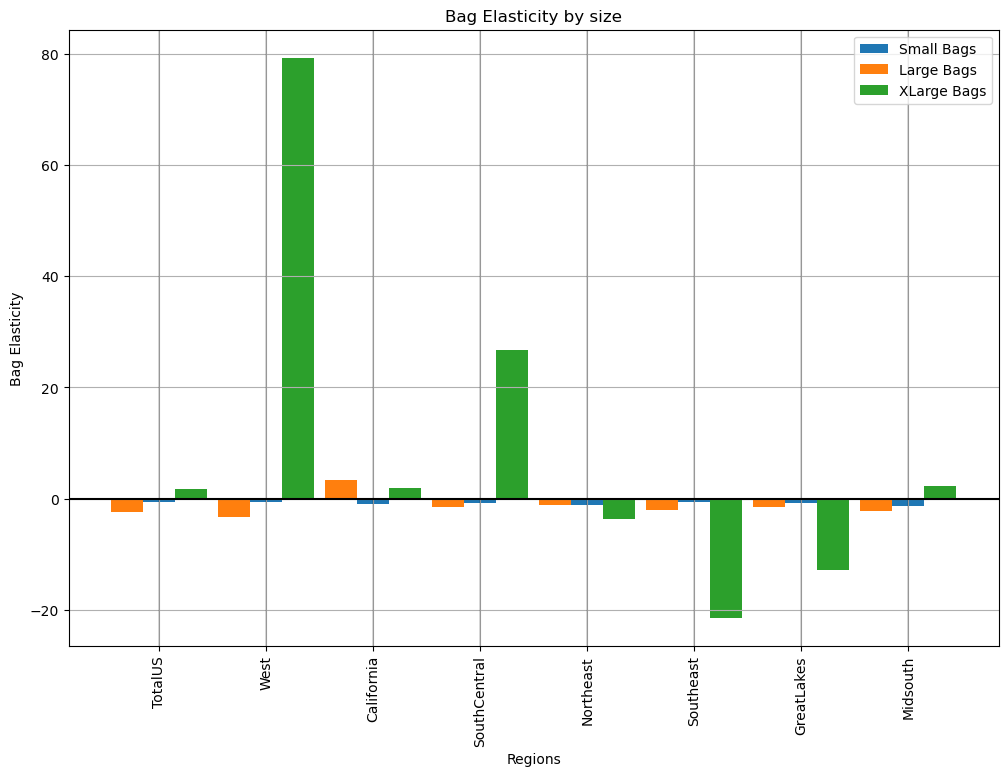

In [ ]:
# Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
#Aqui estem prenent cada regio com equivalentment valida
# cambiar el 2018 no parece afectar los resultados
df_cp_elast = df_cp.copy()
df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'Date'])

region_largest= df_cp_elast.groupby('region')['Total Volume'].sum().nlargest(8).index
type_avocado = 'conventional'
labels = []

small_heights = []
Large_heights = []
XLarge_heights = []

for region in pd.unique(region_largest):
    # region = 'TotalUS'
    elast_region_bags = df_cp_elast[df_cp_elast['region'] == region].copy()
    elast_region_bags = elast_region_bags[elast_region_bags['type'] == type_avocado].copy().reset_index()
    
    # temp_market_size= elast_region['Total Volume'].sum()

    elast_region_bags['Small bag elasticity']= elast_region_bags['Small Bags'].pct_change() /  elast_region_bags['AveragePrice'].pct_change()
    elast_region_bags['Large bag elasticity']= elast_region_bags['Large Bags'].pct_change() /  elast_region_bags['AveragePrice'].pct_change()
    elast_region_bags['XLarge bag elasticity']= elast_region_bags['XLarge Bags'].pct_change() /  elast_region_bags['AveragePrice'].pct_change()
    # elast_region_bags['XLarge bag Variation']= elast_region_bags['AveragePrice'].pct_change()

    # # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net
    elast_region_bags =elast_region_bags[-elast_region_bags['Small bag elasticity'].isin([-np.inf,np.inf])]
    elast_region_bags =elast_region_bags[-elast_region_bags['Large bag elasticity'].isin([-np.inf,np.inf])]
    elast_region_bags =elast_region_bags[-elast_region_bags['XLarge bag elasticity'].isin([-np.inf,np.inf])]

    # Dona problemes a la primera execucio
    #elast_region_bags = elast_region_bags.reset_index()

    small_heights.append(elast_region_bags.loc[1:,'Small bag elasticity'].mean())
    Large_heights.append(elast_region_bags.loc[1:,'Large bag elasticity'].mean())
    XLarge_heights.append(elast_region_bags.loc[1:,'XLarge bag elasticity'].mean())
    labels.append(region)

    if region == 'SouthCentral':
        display(elast_region_bags.loc[10:14,:])# [elast_region_bags['XLarge bag elasticity'] > 200])
        print(elast_region_bags.describe())

fig, ax=plt.subplots(figsize= (12,8))

# Define the positions for the bars on the x-axis
x = np.arange(len(labels))
width = 0.3  # Width of the bars
distance = 0.3

bar1 = ax.bar(x , small_heights, width, label='Small Bags')
bar2 = ax.bar(x - distance , Large_heights, width, label='Large Bags')
bar3 = ax.bar(x + distance, XLarge_heights, width, label='XLarge Bags')

# Labels and title
ax.set_xlabel('Regions')
ax.set_ylabel('Bag Elasticity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Bag Elasticity by size')
plt.axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0

for x_value in x:
    plt.axvline(x_value, color='black', linewidth=0.2, linestyle='-') 
    
plt.xticks(rotation=90)
plt.grid()
# Show the plot
plt.show()

,level_0,index,Date,AveragePrice,Total Volume,Volume_Hass_S,Volume_Hass_L,Volume_Hass_XL,Total Bags,Small Bags,...,XLarge Bags,type,year,region,region_class,Suma Volums,Variacio,Small bag elasticity,Large bag elasticity,XLarge bag elasticity
10,2381,2381,2015-03-15,0.79,5703759.21,3290881.46,1644220.11,115290.48,653367.16,522678.26,...,14.02,conventional,2015,SouthCentral,GreaterRegion,5050392.05,11.455027,2.277216,20.437010,40.465280
11,2380,2380,2015-03-22,0.76,6008817.90,3785376.16,1476714.10,81039.50,665688.14,540561.20,...,23.75,conventional,2015,SouthCentral,GreaterRegion,5343129.76,11.078521,-0.900970,1.122796,-18.275559
12,2379,2379,2015-03-29,0.82,5713017.35,3091049.63,1836365.62,89374.20,696227.90,633029.23,...,38.60,conventional,2015,SouthCentral,GreaterRegion,5016789.45,12.186693,2.166751,-6.271725,7.920000
13,2378,2378,2015-04-05,0.83,6368728.85,3676642.17,1856953.20,104285.22,730848.26,670637.73,...,1528.97,conventional,2015,SouthCentral,GreaterRegion,5637880.59,11.475575,4.871650,-5.814399,3166.070984
14,2377,2377,2015-04-12,0.80,5930072.71,3851189.34,1385674.25,102729.01,590480.11,536034.76,...,21.16,conventional,2015,SouthCentral,GreaterRegion,5339592.60,9.957384,5.552947,2.007227,27.283777


           level_0        index                           Date  AveragePrice  \
count   156.000000   156.000000                            156    156.000000   
mean   5574.416667  5574.416667  2016-08-27 20:46:09.230769152      0.872372   
min    2341.000000  2341.000000            2015-01-04 00:00:00      0.620000   
25%    2383.500000  2383.500000            2015-11-06 06:00:00      0.780000   
50%    5182.500000  5182.500000            2016-09-07 12:00:00      0.835000   
75%    8024.250000  8024.250000            2017-06-19 18:00:00      0.932500   
max    9029.000000  9029.000000            2018-03-25 00:00:00      1.340000   
std    2450.562342  2450.562342                            NaN      0.143487   

       Total Volume  Volume_Hass_S  Volume_Hass_L  Volume_Hass_XL  \
count  1.560000e+02   1.560000e+02   1.560000e+02      156.000000   
mean   5.876758e+06   3.127538e+06   1.293206e+06   125474.259487   
min    3.733135e+06   1.193350e+06   7.136460e+05     6332.780000   
25%

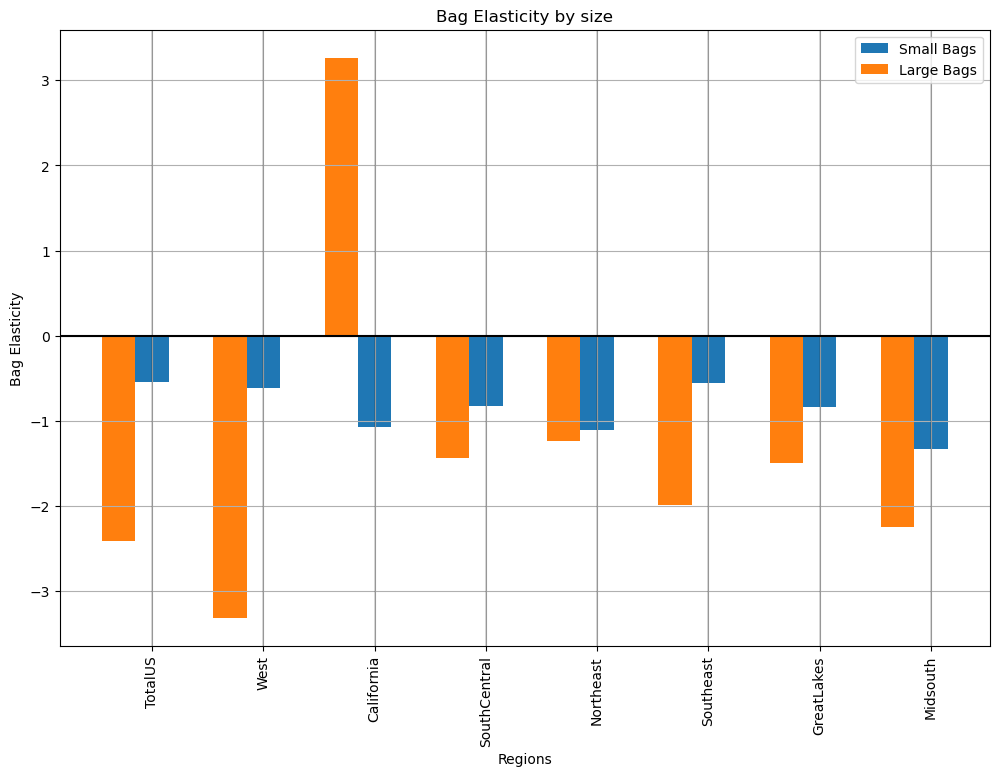

In [6]:
# Aqui podem veure que a majors mercats el preu mig tendeix a abaratirse. 
#Aqui estem prenent cada regio com equivalentment valida
# cambiar el 2018 no parece afectar los resultados
df_cp_elast = df_cp.copy()
df_cp_elast= df_cp_elast.sort_values(by=['region','type', 'Date'])

region_largest= df_cp_elast.groupby('region')['Total Volume'].sum().nlargest(8).index
type_avocado = 'conventional'
labels = []

small_heights = []
Large_heights = []
XLarge_heights = []

for region in pd.unique(region_largest):
    # region = 'TotalUS'
    elast_region_bags = df_cp_elast[df_cp_elast['region'] == region].copy()
    elast_region_bags = elast_region_bags[elast_region_bags['type'] == type_avocado].copy().reset_index()
    
    # temp_market_size= elast_region['Total Volume'].sum()

    elast_region_bags['Small bag elasticity']= elast_region_bags['Small Bags'].pct_change() /  elast_region_bags['AveragePrice'].pct_change()
    elast_region_bags['Large bag elasticity']= elast_region_bags['Large Bags'].pct_change() /  elast_region_bags['AveragePrice'].pct_change()
    elast_region_bags['XLarge bag elasticity']= elast_region_bags['XLarge Bags'].pct_change() /  elast_region_bags['AveragePrice'].pct_change()
    # elast_region_bags['XLarge bag Variation']= elast_region_bags['AveragePrice'].pct_change()

    # # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net
    elast_region_bags =elast_region_bags[-elast_region_bags['Small bag elasticity'].isin([-np.inf,np.inf])]
    elast_region_bags =elast_region_bags[-elast_region_bags['Large bag elasticity'].isin([-np.inf,np.inf])]
    elast_region_bags =elast_region_bags[-elast_region_bags['XLarge bag elasticity'].isin([-np.inf,np.inf])]

    # Dona problemes a la primera execucio
    #elast_region_bags = elast_region_bags.reset_index()

    small_heights.append(elast_region_bags.loc[1:,'Small bag elasticity'].mean())
    Large_heights.append(elast_region_bags.loc[1:,'Large bag elasticity'].mean())
    XLarge_heights.append(elast_region_bags.loc[1:,'XLarge bag elasticity'].mean())
    labels.append(region)

    if region == 'SouthCentral':
        display(elast_region_bags.loc[10:14,:])# [elast_region_bags['XLarge bag elasticity'] > 200])
        print(elast_region_bags.describe())

fig, ax=plt.subplots(figsize= (12,8))

# Define the positions for the bars on the x-axis
x = np.arange(len(labels))
width = 0.3  # Width of the bars
distance = 0.3

bar1 = ax.bar(x , small_heights, width, label='Small Bags')
bar2 = ax.bar(x - distance , Large_heights, width, label='Large Bags')
#bar3 = ax.bar(x + distance, XLarge_heights, width, label='XLarge Bags')

# Labels and title
ax.set_xlabel('Regions')
ax.set_ylabel('Bag Elasticity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title('Bag Elasticity by size')
plt.axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0

for x_value in x:
    plt.axvline(x_value, color='black', linewidth=0.2, linestyle='-') 
    
plt.xticks(rotation=90)
plt.grid()
# Show the plot
plt.show()

#### Repetir estudio, pero solo USA

In [ ]:
df_USA= df_cp[df_cp['region'] == 'TotalUS'].copy()
df_USA= df_USA.sort_values(by=['Date'])
df_USA_org = df_USA[df_USA['type'] == 'organic'].copy()
df_USA_org['Elasticity'] = df_USA_org['Total Volume'].pct_change() /  df_USA_org['AveragePrice'].pct_change()
df_USA_org =df_USA_org[-df_USA_org['Elasticity'].isin([-np.inf,np.inf])].reset_index()
df_USA_org = df_USA_org.loc[1:,]


df_USA_conv = df_USA[df_USA['type'] == 'conventional'].copy()
df_USA_conv['Elasticity'] = df_USA_conv['Total Volume'].pct_change() /  df_USA_conv['AveragePrice'].pct_change()
df_USA_conv =df_USA_conv[-df_USA_conv['Elasticity'].isin([-np.inf,np.inf])].reset_index()
df_USA_conv = df_USA_conv.loc[1:,]

In [ ]:
# Creem el group by adient
organic_year_USA = df_USA_org.groupby("year").agg({'Elasticity':"mean"})
conv_year_USA = df_USA_conv.groupby("year").agg({'Elasticity':"mean"})

#Plotejem
fig, ax = plt.subplots()
organic_year_USA.loc[:,'Elasticity'].plot(kind = 'line',ax= ax, color= 'green', label = 'Organic' )
conv_year_USA.loc[:,'Elasticity'].plot(kind = 'line',ax= ax, color= 'gray', label = 'Convencional' )
plt.legend()
ax.set_xticks(conv_year_USA.index)
ax.grid()
plt.title('Sorted year elasticity')

In [ ]:
#Plotejem
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(df_USA_org['Date'],  df_USA_org['Elasticity'], color= 'green', label= 'Organic' )
plt.scatter(df_USA_conv['Date'],  df_USA_conv['Elasticity'], color= 'Gray', label= 'Conventional' )
# ax.set_xticks(conv_year_USA.index)
ax.axhline(0, color='black', linewidth=1.5, linestyle='-')  # Horizontal line at y=0
ax.grid()
# plt.ylim(-10,10)
plt.legend()
plt.title('Sorted Date elasticity -TotalUS-')

In [ ]:
# # Creacion de la variable elasticidad y eliminacion de valores no utiles
# df_cp_elast_bags = df_USA[df_USA['type']=='conventional'].copy().sort_values(by=['region', 'Date']).reset_index()

# df_cp_elast_bags['Small bag elasticity']= df_cp_elast_bags['Small Bags'].pct_change() /  df_cp_elast_bags['AveragePrice'].pct_change()
# df_cp_elast_bags['Large bag elasticity']= df_cp_elast_bags['Large Bags'].pct_change() /  df_cp_elast_bags['AveragePrice'].pct_change()
# df_cp_elast_bags['XLarge bag elasticity']= df_cp_elast_bags['XLarge Bags'].pct_change() /  df_cp_elast_bags['AveragePrice'].pct_change()

# # # Els possibles valors entre infinit i menys infinit son ignorats per a un subset net
# df_cp_elast_bags =df_cp_elast_bags[-df_cp_elast_bags['Small bag elasticity'].isin([-np.inf,np.inf])]
# df_cp_elast_bags =df_cp_elast_bags[-df_cp_elast_bags['Large bag elasticity'].isin([-np.inf,np.inf])]
# df_cp_elast_bags =df_cp_elast_bags[-df_cp_elast_bags['XLarge bag elasticity'].isin([-np.inf,np.inf])]

# df_cp_elast_bags = df_cp_elast_bags.loc[1:,:]

In [ ]:
# bag_means = df_cp_elast_bags.loc[:,['Small bag elasticity','Large bag elasticity','XLarge bag elasticity']].mean()

# labels= ['Small bag elasticity','Large bag elasticity','XLarge bag elasticity']

# plt.bar(x=labels, height = bag_means, color = ('y', 'orange', 'r'))
# plt.grid()

#### Analisis por cohortes

##### 1. Cohortes Basadas en Precios Promedios Trimestrales:

In [ ]:
df_cp_cleaned = df_cp.copy()
df_USA = df_cp_cleaned[df_cp_cleaned['region']=='TotalUS'].copy()
df_USA = df_USA[df_USA['type']=='conventional']#.copy()
df_media = df_USA.groupby([pd.Grouper(key='Date', freq='QS')]).agg({'AveragePrice':'mean', 'Total Volume':'sum'}).reset_index()
df_media = df_USA.groupby(['Date']).agg({'AveragePrice':'mean', 'Total Volume':'sum'}).reset_index()
#df_media['Date offset'] = df_media['Date'] - pd.DateOffset(months=5)
# display(df_temp)

fig, ax1 = plt.subplots(figsize=(12,4))
plt.title('Estudio de precios')
color = 'tab:red'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Volum ventas', color=color)
ax1.plot(df_media['Date'], df_media['Total Volume'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Average Price', color=color)  # we already handled the x-label with ax1
ax2.plot(df_media['Date'], df_media['AveragePrice'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
# plt.ylim(0, 5)
#ax2.grid(color=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(rotation = 90)
plt.show()

##### 2. Cohortes por Región y Fecha:

In [ ]:
df_no_USA = df_cp_cleaned[df_cp_cleaned['region']=='California']
df_media = df_no_USA.groupby(['region', 'year']).agg({'Total Volume':'sum', 'AveragePrice':'mean'})#.reset_index()

df_media['Total Volume'].plot(kind='bar', label = 'Total Volume', color= 'orange')
plt.show()

df_media['AveragePrice'].plot(kind='bar', label = 'Average Price', color= 'green')
plt.show()

##### 3. Análisis de Cohortes en Función del Tipo de Bolsa:

In [ ]:
columnas_bags = ['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
# df_bag_temp = df_cp_cleaned[df_cp_cleaned['region']=='Philadelphia'].copy()
df_bag_temp = df_cp_cleaned.copy()
df_bag_temp= df_cp_cleaned.groupby('Date')['Total Bags'].sum()

fig, ax= plt.subplots()
for title_bag in columnas_bags: 
    df_bag_temp= df_cp_cleaned.groupby('Date')[title_bag].sum()
    df_bag_temp.plot(kind = 'line', ax=ax, label= title_bag)

plt.yscale('log')
plt.title('Logarithmic')
plt.grid()
plt.legend()
plt.show()

In [ ]:
columnas_bags = ['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
fig, ax= plt.subplots()
for title_bag in columnas_bags:
    df_bag_temp= df_cp_cleaned.groupby('Date')[title_bag].sum()
    df_bag_temp.plot(kind = 'line', ax=ax, label= title_bag)

# plt.yscale('log')   
plt.grid()
plt.legend()
plt.show()

In [ ]:
columnas_bags = ['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
fig, ax= plt.subplots()
for title_bag in columnas_bags:
    df_bag_temp= df_cp_cleaned.groupby([pd.Grouper(key='Date', freq='QS')])[title_bag].sum()
    df_bag_temp.plot(kind = 'line', ax=ax, label= title_bag)

# plt.yscale('log')   
plt.grid()
plt.legend()
plt.show()

##### 4. Cohortes de Clientes Basadas en Ventas:

In [ ]:
df_cleaned_great_regions = df_cp_cleaned[df_cp_cleaned['region_class']=='GreaterRegion']
# df_cleaned_great_regions = df_cleaned_great_regions[(df_cleaned_great_regions['Date']<'15-03-2018')&(df_cleaned_great_regions['Date']>'01-01-2018')]
great_regions = pd.unique(df_cleaned_great_regions['region'])

fig, ax= plt.subplots(figsize=(20,8))
for region in great_regions:
    df_temp_region = df_cleaned_great_regions[df_cleaned_great_regions['region'] ==region ]
    df_date_region= df_temp_region.groupby('Date')['Total Volume'].sum()
    df_date_region.plot(kind = 'line', ax=ax, label= region)

# plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [ ]:
df_cleaned_great_regions = df_cp_cleaned[df_cp_cleaned['region_class']=='GreaterRegion']
df_cleaned_great_regions = df_cleaned_great_regions[(df_cleaned_great_regions['Date']<'2017-06-15')&(df_cleaned_great_regions['Date']>'2017-04-15')]
great_regions = pd.unique(df_cleaned_great_regions['region'])

fig, ax= plt.subplots(figsize=(12,4))
for region in great_regions:
    df_temp_region = df_cleaned_great_regions[df_cleaned_great_regions['region'] ==region ]
    df_date_region= df_temp_region.groupby('Date')['Total Volume'].sum()
    df_date_region.plot(kind = 'line', ax=ax, label= region)

# plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

##### 5. Evaluación de Retención de Ventas por Cohorte:

In [ ]:
df_cleaned_great_regions = df_cp_cleaned[df_cp_cleaned['region_class']=='GreaterRegion']
# df_cleaned_great_regions = df_cleaned_great_regions[(df_cleaned_great_regions['Date']<'15-03-2018')&(df_cleaned_great_regions['Date']>'01-01-2018')]
great_regions = pd.unique(df_cleaned_great_regions['region'])

fig, ax= plt.subplots(figsize=(20,8))
for region in great_regions:
    df_temp_region = df_cleaned_great_regions[df_cleaned_great_regions['region'] ==region ]
    df_date_region= df_temp_region.groupby([pd.Grouper(key='Date', freq='MS')])['Total Volume'].sum()
    df_date_region.plot(kind = 'line', ax=ax, label= region)

# plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

#### Matriz de correlaciones de todas las variables según  apartado 5.6. En especial, precio medio y relación con diferentes calibres.

In [ ]:
df_corr_gen= df_cp.copy()
df_corr_gen = df_corr_gen[df_corr_gen['region']=='Philadelphia']
# df_corr_gen = df_corr_gen[(df_corr_gen['region_class']== 'City') | (df_corr_gen['region_class']== 'Region')]

corr_df= df_corr_gen[['AveragePrice', 'Total Volume', 'Total Bags' ,'Volume_Hass_S', 'Volume_Hass_L', 'Volume_Hass_XL']]
# Calcular la matriz de correlación
corr_matrix = corr_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación (Philadelphia)')
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    if any((corr_matrix[column].abs() > threshold) & (corr_matrix.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras: {to_drop}")

#### Dispersión entre variables claves según 5.2

In [ ]:
df_local = df_cp.copy()
df_local= df_local[df_local['type']=='organic']
df_local= df_local[df_local['region']=='TotalUS']
df_local = df_local[df_local['AveragePrice']==1.0]
display(df_local)

* TODO ?

In [ ]:
# df_local = df_cp.copy()
# df_local= df_local[df_local['type']=='conventional']

# # df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
# df_local_USA=df_local[df_local['region_class']=='TotalUS']

# fig, ax= plt.subplots(figsize=(10,6))

# # sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
# sns.regplot(data= df_local_USA , x=df_local_USA['Total Volume'], y=df_local_USA['AveragePrice'], order=1)#, line=True)
# plt.xscale('log')
# plt.grid()
# plt.title('Conventional')
# plt.figure()

In [ ]:
df_local = df_cp.copy()
df_local= df_local[df_local['type']=='organic']

# df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
df_local_USA=df_local[df_local['region_class']=='TotalUS']

fig, ax= plt.subplots(figsize=(10,6))

# sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
sns.regplot(data= df_local_USA , x=df_local_USA['Total Volume'], y=df_local_USA['AveragePrice'], order=1)#, line=True)
plt.xscale('log')
plt.grid()
plt.title('TotalUS')
plt.figure()
plt.show()

In [ ]:
df_local = df_cp.copy()
df_local= df_local[df_local['type']=='organic']

# df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
df_local_USA=df_local[df_local['region_class']=='TotalUS']
df_local_USA=df_local_USA[df_local_USA['AveragePrice']>1.1]

fig, ax= plt.subplots(figsize=(10,6))

# sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
sns.regplot(data= df_local_USA , x=df_local_USA['Total Volume'], y=df_local_USA['AveragePrice'], order=1)#, line=True)
plt.xscale('log')
plt.grid()
plt.title('TotalUS Organic')
plt.figure()
plt.show()

# df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
df_local_region=df_local[df_local['region_class']=='City']

fig, ax= plt.subplots(figsize=(10,6))

# sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
sns.regplot(data= df_local_region , x=df_local_region['Total Volume'], y=df_local_region['AveragePrice'], order=1)#, line=True)
plt.xscale('log')
plt.title('City Organic')
plt.grid()
plt.figure()
plt.show()

In [ ]:
df_local = df_cp.copy()
df_local= df_local[df_local['type']=='organic']

# df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
df_local_USA=df_local[df_local['region_class']=='TotalUS']

fig, ax= plt.subplots(figsize=(10,6))

# sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
sns.regplot(data= df_local_USA , x=df_local_USA['Total Volume'], y=df_local_USA['AveragePrice'], order=1)#, line=True)
plt.xscale('log')
plt.grid()
plt.title('TotalUS')
plt.figure()
plt.show()

# df_local = df_cp[(df_cp['region']!='TotalUS')&(df_cp['region_class']!='GreaterRegion')].copy()
df_local_region=df_local[df_local['region_class']=='City']

fig, ax= plt.subplots(figsize=(10,6))

# sns.scatterplot(data= df_local , x=df_local['Total Volume'], y=df_local['AveragePrice'], alpha= 0.1)
sns.regplot(data= df_local_region , x=df_local_region['Total Volume'], y=df_local_region['AveragePrice'], order=1)#, line=True)
plt.xscale('log')
plt.title('City')
plt.grid()
plt.figure()
plt.show()

# REGRESIONES Y PROYECCIONES

## Ejemplo De Modelo Final

In [ ]:
df_local = df_cp.copy()
df_local = df_local.sort_values(by=['region', 'type', 'year'])
display(df_local)

#### West: Primer ejemplo del modelo Final que vamos a mostrar. Incluye un plotting avanzado y las variables X más importantes

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import datetime

df_local = df_cp.copy()

df_local=df_local[df_local['region']=='West']

bool_org= {'organic':1, 'conventional':0}

df_local['Month'] = df_local['Date'].dt.to_period('M')
df_local['Quarter'] = df_local['Date'].dt.to_period('Q')
df_local['n_week'] = df_local['Date'].dt.isocalendar().week#.dt.to_period('W').strftime('%V')
df_local['Quarter Month'] = df_local['Month'].map(lambda x: (x.month - 1) % 3 + 1 )
df_local['n_Quarter'] = df_local['Month'].map(lambda date: (date.month - 1) // 3 + 1)
df_local['type_Bool'] = df_local['type'].map(bool_org)

df_local['Standard Volume'] = (df_local['Total Volume'] - df_local['Total Volume'].mean()) /df_local['Total Volume'].std()
df_local['ST_Volume_Hass_S'] = (df_local['Volume_Hass_S'] - df_local['Volume_Hass_S'].mean()) /df_local['Volume_Hass_S'].std()
df_local['ST_Volume_Hass_L'] = (df_local['Volume_Hass_L'] - df_local['Volume_Hass_L'].mean()) /df_local['Volume_Hass_L'].std()
df_local['ST_Volume_Hass_XL'] = (df_local['Volume_Hass_XL'] - df_local['Volume_Hass_XL'].mean()) /df_local['Volume_Hass_XL'].std()
df_local['Standard Bags'] = (df_local['Total Bags'] - df_local['Total Bags'].mean()) /df_local['Total Bags'].std()

# display(df_local)
Variables = ['Standard Volume', 'year','n_week', 'type_Bool'] #,,,  , 'ST_Volume_Hass_XL',  'ST_Volume_Hass_S', 'ST_Volume_Hass_L' , 'Standard Bags', 'n_Quarter'
# group_fit = df_fit.groupby('Quarter').agg({'AveragePrice':'mean', 'Total Volume':'mean' }).reset_index()
X= df_local[Variables]
Y= df_local['AveragePrice']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

###########
# Aplicar un modelo de regresión lineal para interpolar
poly_features = PolynomialFeatures(degree=3)
poly_model = LinearRegression()

X_poly = poly_features.fit_transform(X_train)
print(f"X_poly: {len(X_poly)} {X_poly}")
poly_model.fit(X_poly, y_train)
y_pred_poly_train = poly_model.predict(X_poly)

X_test_poly= poly_features.fit_transform(X_test)
y_pred_poly_test = poly_model.predict(X_test_poly)

y_pred_poly_train = poly_model.predict(X_poly)

# Comparar los primeros 10 valores entre el valor predicho y el valor real
comparison_df = pd.DataFrame({
    'Valor Real': y_test.head(10).values,
    'Valor Predicho': y_pred_poly_test[:10]
})

# Calcular el error porcentual
comparison_df['Error Porcentual'] = ((comparison_df['Valor Real'] - comparison_df['Valor Predicho']) / comparison_df['Valor Real']) * 100

print("\nComparación de los primeros 10 valores entre el valor predicho y el valor real:\n", comparison_df)


# Calcular el error cuadrático medio (MSE) para evaluar el modelo
mse = mean_squared_error(y_test, y_pred_poly_test)
print(f"\nError cuadrático medio (MSE) del modelo: {mse:.4f}")


for i in range(0, len(Variables)):
    
    print(f'El coeficiente {Variables[i]}\t \t: {poly_model.coef_[i]}')

# Calcular el valor R²
r2_test = r2_score(y_test, y_pred_poly_test)
r2_train = r2_score(y_train, y_pred_poly_train)

print(f"\nValor R² del modelo: {r2_test:.6f}")
print(f"\nLa diferencia entre los Valores R² del modelo: {r2_train- r2_test:.6f}")



#############################################################################################################
# Plotting


fig, ax= plt.subplots(figsize= (10,5))

X_to_plot = X_train[X_train['type_Bool']==0]
X_to_plot.loc[:,'Date'] = X_to_plot.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)


y_pred_plot = y_pred_poly_train[X_train['type_Bool']==0]
Y_to_plot = y_train[X_train['type_Bool']==0]



plt.scatter(x = X_to_plot['Date'], y= y_pred_plot, color= 'Skyblue', label = 'Predicción modelo')
plt.scatter(x = X_to_plot['Date'], y= Y_to_plot, color= 'blue',  label = 'Valores reales')
plt.title("Average Price en West")
plt.legend()
plt.grid()
plt.show()
# print(X_train, y_pred_poly_train)

## Comparación de módelos

In [ ]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import datetime
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import avocado_manager as av



color_orga ='green'; color_conv ='grey'; color_total ='blue'
av.init()
df_cp = av.df("df_cp")


df_local = df_cp.copy()

bool_org= {'organic':1, 'conventional':0}

df_local['Month'] = df_local['Date'].dt.to_period('M')
df_local['Quarter'] = df_local['Date'].dt.to_period('Q')
df_local['n_week'] = df_local['Date'].dt.isocalendar().week#.dt.to_period('W').strftime('%V')
df_local['Quarter Month'] = df_local['Month'].map(lambda x: (x.month - 1) % 3 + 1 )
df_local['n_Quarter'] = df_local['Month'].map(lambda date: (date.month - 1) // 3 + 1)
df_local['type_Bool'] = df_local['type'].map(bool_org)

df_local['Standard Volume'] = (df_local['Total Volume'] - df_local['Total Volume'].mean()) /df_local['Total Volume'].std()
df_local['ST_Volume_Hass_S'] = (df_local['Volume_Hass_S'] - df_local['Volume_Hass_S'].mean()) /df_local['Volume_Hass_S'].std()
df_local['ST_Volume_Hass_L'] = (df_local['Volume_Hass_L'] - df_local['Volume_Hass_L'].mean()) /df_local['Volume_Hass_L'].std()
df_local['ST_Volume_Hass_XL'] = (df_local['Volume_Hass_XL'] - df_local['Volume_Hass_XL'].mean()) /df_local['Volume_Hass_XL'].std()
df_local['Standard Bags'] = (df_local['Total Bags'] - df_local['Total Bags'].mean()) /df_local['Total Bags'].std()

In [ ]:
diccionario_regressiones = {'Region' : [], 
                            'Variables' : [], 
                            'R_2' : [], 
                            'Var_R' : [] , 
                            'Random_seed' : []}
                           # 'TotalUS comp' : []}

In [ ]:
Variables = ['Standard Volume', 'year','n_week', 'type_Bool'] #,,,  , , 'ST_Volume_Hass_XL',  'ST_Volume_Hass_S', 'ST_Volume_Hass_L' , 'Standard Bags', 'n_Quarter'
for region in pd.unique(df_local['region'] ):

    for random_seed in range(0,5): # 30 para la presentacion si queremos mosrt

        df_temp_region = df_local[df_local['region'] == region]
    
        X= df_temp_region[Variables]
        Y= df_temp_region['AveragePrice']
    
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=random_seed)
    
        
    
        ###########
        # Aplicar un modelo de regresión lineal para interpolar
        poly_features = PolynomialFeatures(degree=9)
        poly_model = LinearRegression()
        
        X_poly = poly_features.fit_transform(X_train)
        poly_model.fit(X_poly, y_train)
        y_pred_poly_train = poly_model.predict(X_poly)
        
        X_test_poly= poly_features.fit_transform(X_test)
        y_pred_poly_test = poly_model.predict(X_test_poly)
        
        y_pred_poly_train = poly_model.predict(X_poly)
        
        
        # Calcular el valor R²
        r2_test = r2_score(y_test, y_pred_poly_test)
        r2_train = r2_score(y_train, y_pred_poly_train)
    
    
    
        # ########USA
        # # Calcular el valor R²
    
        # df_temp_USA = df_local[df_local['region'] == 'TotalUS']
    
        # X_USA= df_temp_USA[Variables]
        # Y_USA= df_temp_USA['AveragePrice']   
    
        # X_USA_train, X_USA_test, y_USA_train, y_USA_test = train_test_split(X_USA, Y_USA, test_size=0.2, random_state=random_seed)
        # X_poly_USA_train = poly_features.fit_transform(X_USA_train)
        
        # y_pred_USA_train = poly_model.predict(X_poly_USA_train)
        # r2_USA_train = r2_score(y_USA_train, y_pred_USA_train)
    
    
            # Calcular el valor R²
        r2_test = r2_score(y_test, y_pred_poly_test)
        r2_train = r2_score(y_train, y_pred_poly_train)
    
        diccionario_regressiones['Region'].append(region)
        diccionario_regressiones['Variables'].append(Variables)
        diccionario_regressiones['R_2'].append(r2_test)
        diccionario_regressiones['Var_R'].append(abs(r2_train - r2_test))
        diccionario_regressiones['Random_seed'].append(random_seed)


Resultados_df= pd.DataFrame(diccionario_regressiones)


best_regions = Resultados_df.groupby('Region')['R_2'].max()

display(Resultados_df[Resultados_df['Region'] == 'California'].sort_values(by = 'R_2', ascending = False))

## Modelo de predicción

### Inicializacion

In [ ]:
from sklearn import preprocessing
import pandas as pd
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
region_classification = av.region_classification

### Modelo Predicción variables independientes (Total Volume)

### Entrenamiento modelo Total Volume

In [ ]:
# Para poder predecir el average price en un periodo que no conocemos, 
# Necesitamos predecir previamente el volúmen de venta o Total Volume
# Este modelo sera por una sola región, Californai

df = pd.read_csv("avocado.csv")
df_cp = df.copy()
df_cp['Date'] = pd.to_datetime(df_cp['Date'])

df_cp['region_class']= df_cp['region'].map(region_classification)

df_cp = df_cp.rename(columns={df.columns[0]: 'Col_0'}) # Primera columna sin titulo, potencialmente eliminable
df_cp = df_cp.rename(columns={'4046': 'Volume_Hass_S'}) # Etiquetas mas descritivas
df_cp = df_cp.rename(columns={'4225': 'Volume_Hass_L'})
df_cp = df_cp.rename(columns={'4770': 'Volume_Hass_XL'})

df_modelo_volume= df_cp.copy()
# df_modelo_volume= df_modelo_volume[df_modelo_volume['region'] == 'California']

bool_org= {'organic':1, 'conventional':0}

df_modelo_volume['Month'] = df_modelo_volume['Date'].dt.to_period('M')
df_modelo_volume['Quarter'] = df_modelo_volume['Date'].dt.to_period('Q')
df_modelo_volume['n_week'] = df_modelo_volume['Date'].dt.isocalendar().week#.dt.to_period('W').strftime('%V')
df_modelo_volume['Quarter Month'] = df_modelo_volume['Month'].map(lambda x: (x.month - 1) % 3 + 1 )
df_modelo_volume['n_Quarter'] = df_modelo_volume['Month'].map(lambda date: (date.month - 1) // 3 + 1)
df_modelo_volume['type_Bool'] = df_modelo_volume['type'].map(bool_org)


In [ ]:
# Creación de modelo total Volume

Variables_vol = ['year','n_week', 'type_Bool']

df_temp_region = df_modelo_volume[df_modelo_volume['region'] == 'California']


X_Volume= df_temp_region[Variables_vol]
Y_Volume= df_temp_region['Total Volume']

X_train_vol, X_test_vol, y_train_vol, y_test_vol = train_test_split(X_Volume, Y_Volume, test_size=0.1, random_state=42) # TODO escoger random seed

###########
# Training the volume prediction model
vol_poly_features = PolynomialFeatures(degree=7)
vol_poly_model = LinearRegression()

X_poly_train_vol = vol_poly_features.fit_transform(X_train_vol)
vol_poly_model.fit(X_poly_train_vol, y_train_vol)
y_pred_vol_train = vol_poly_model.predict(X_poly_train_vol)

X_poly_test_vol= vol_poly_features.fit_transform(X_test_vol)
y_pred_vol_test = vol_poly_model.predict(X_poly_test_vol)

# Calcular el valor R²
r2_test = r2_score(y_test_vol, y_pred_vol_test)
r2_train = r2_score(y_train_vol, y_pred_vol_train)

print(f"\nValor R² del modelo: {r2_test:.6f}")
print(f"\nLa diferencia entre los Valores R² del modelo: {r2_train- r2_test:.6f}")


### Visualización modelo total Volume

* En este apartado visualizaremos lso resultados del modelo de total Volume. En este caso como las variables independientes son únicamente temporales es muy dificil poder obtener un valor suficientemente certero. Aun asi esta estimación sera suficiente por el momento.


In [ ]:
# Visualcización del modelo de total Volume
fig, ax= plt.subplots(figsize= (10,5))

tipo_aguacate_plot = 0

X_to_plot = X_train_vol[X_train_vol['type_Bool']==tipo_aguacate_plot]
X_to_plot.loc[:,'Date'] = X_to_plot.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)


y_pred_plot = y_pred_vol_train[X_train_vol['type_Bool']==tipo_aguacate_plot]
Y_to_plot = y_train_vol[X_train_vol['type_Bool']==tipo_aguacate_plot]

plt.scatter(x = X_to_plot['Date'], y= y_pred_plot, color= 'Skyblue', label= 'Valores Modelo')
plt.scatter(x = X_to_plot['Date'], y= Y_to_plot, color= 'blue', label= 'Valores Reales')
plt.ylabel('Total Volume')
plt.grid()
plt.legend()
plt.show()

### Prediccion Total Volume

In [ ]:
#df_temp_region

X_for_vol = pd.DataFrame()

# Number of dates you want in the list
length_prediction = 200

#start_date = df_temp_region['Date'].max()#.min()
start_date = datetime.datetime.strptime( '2015-01-01', '%Y-%m-%d')#.timestamp()#.date()#'2018-01-01'

#print(type(start_date))
# start_date = datetime.datetime(01,01,2018)
interval = datetime.timedelta(days=7)

# Generate X values needed for prediction
X_for_vol['Date'] = pd.DataFrame([start_date + i * interval for i in range(length_prediction)])

X_for_vol['n_week'] = X_for_vol['Date'].dt.isocalendar().week
X_for_vol['year'] = X_for_vol['Date'].dt.year
X_for_vol['type_Bool'] = 0

X_for_vol = X_for_vol[Variables_vol]
#X_for_vol


In [ ]:
X_poly_for_vol= vol_poly_features.fit_transform(X_for_vol)
vol_prediction = vol_poly_model.predict(X_poly_for_vol)

### Visualizacion predicciones total Volume

In [ ]:
X_for_vol_temp = X_for_vol.copy()

fig, ax= plt.subplots(figsize= (10,5))

tipo_aguacate_plot = 0

X_to_plot = X_train_vol[X_train_vol['type_Bool']==tipo_aguacate_plot]
X_to_plot.loc[:,'Date'] = X_to_plot.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)

X_for_vol_temp.loc[:,'Date'] = X_for_vol_temp.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)

y_pred_plot = y_pred_vol_train[X_train_vol['type_Bool']==tipo_aguacate_plot]
Y_to_plot = y_train_vol[X_train_vol['type_Bool']==tipo_aguacate_plot]

plt.scatter(x = X_to_plot['Date'], y= y_pred_plot, color= 'Skyblue', label= 'Valores Modelo')
plt.scatter(x = X_to_plot['Date'], y= Y_to_plot, color= 'blue', label= 'Valores Reales')
plt.scatter(x = X_for_vol_temp['Date'], y= vol_prediction, color= 'Skyblue', label= 'Valores Modelo')
plt.ylabel('Total Volume')
plt.grid()
plt.legend()
plt.show()


## Creación Modelo Variable dependiente

In [ ]:
df = pd.read_csv("avocado.csv")
df_cp = df.copy()
df_cp['Date'] = pd.to_datetime(df_cp['Date'])

df_cp['region_class']= df_cp['region'].map(region_classification)

df_cp = df_cp.rename(columns={df.columns[0]: 'Col_0'}) # Primera columna sin titulo, potencialmente eliminable
df_cp = df_cp.rename(columns={'4046': 'Volume_Hass_S'}) # Etiquetas mas descritivas
df_cp = df_cp.rename(columns={'4225': 'Volume_Hass_L'})
df_cp = df_cp.rename(columns={'4770': 'Volume_Hass_XL'})

df_modelo_avprice_total= df_cp.copy()
# df_modelo_volume= df_modelo_volume[df_modelo_volume['region'] == 'California']

bool_org= {'organic':1, 'conventional':0}

df_modelo_avprice_total['Month'] = df_modelo_avprice_total['Date'].dt.to_period('M')
df_modelo_avprice_total['Quarter'] = df_modelo_avprice_total['Date'].dt.to_period('Q')
df_modelo_avprice_total['n_week'] = df_modelo_avprice_total['Date'].dt.isocalendar().week#.dt.to_period('W').strftime('%V')
df_modelo_avprice_total['Quarter Month'] = df_modelo_avprice_total['Month'].map(lambda x: (x.month - 1) % 3 + 1 )
df_modelo_avprice_total['n_Quarter'] = df_modelo_avprice_total['Month'].map(lambda date: (date.month - 1) // 3 + 1)
df_modelo_avprice_total['type_Bool'] = df_modelo_avprice_total['type'].map(bool_org)
df_modelo_avprice_total['Standard Volume'] = (df_modelo_avprice_total['Total Volume'] - df_modelo_avprice_total['Total Volume'].mean()) /df_modelo_avprice_total['Total Volume'].std()

#print(df_modelo_avprice['Total Volume'].mean() , df_modelo_avprice['Total Volume'].std())

In [ ]:
# Creación de modelo total Volume

Variables_avprice = ['Standard Volume', 'year','n_week', 'type_Bool']

df_modelo_avprice = df_modelo_avprice_total[df_modelo_avprice_total['region'] == 'California']

X_Price= df_modelo_avprice[Variables_avprice]
Y_Price= df_modelo_avprice['AveragePrice']

X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X_Price, Y_Price, test_size=0.1, random_state=20) # TODO escoger random seed


###########
# Training the volume prediction model
price_poly_features = PolynomialFeatures(degree=9)
price_poly_model = LinearRegression()

X_poly_train_price = price_poly_features.fit_transform(X_train_price)
price_poly_model.fit(X_poly_train_price, y_train_price)
y_pred_price_train = price_poly_model.predict(X_poly_train_price)

X_poly_test_price= price_poly_features.fit_transform(X_test_price)
y_pred_price_test = price_poly_model.predict(X_poly_test_price)

# Calcular el valor R²
r2_test = r2_score(y_test_price, y_pred_price_test)
r2_train = r2_score(y_train_price, y_pred_price_train)

print(f"\nValor R² del modelo: {r2_test:.6f}")
print(f"\nLa diferencia entre los Valores R² del modelo: {r2_train- r2_test:.6f}")

# # Comparar los primeros 10 valores entre el valor predicho y el valor real
# comparison_df = pd.DataFrame({
#     'Valor Real': y_test_price.head(10).values,
#     'Valor Predicho': y_pred_price_test[:10]
# })
# # TODO COMPROVAR VALORES
# # Calcular el error porcentual
# comparison_df['Error Porcentual'] = ((comparison_df['Valor Real'] - comparison_df['Valor Predicho']) / comparison_df['Valor Real']) * 100

# print("\nComparación de los primeros 10 valores entre el valor predicho y el valor real:\n", comparison_df)

## Predicción Variable Dependiente

In [ ]:
X_for_vol ['Total Volume'] = vol_prediction

X_for_vol['Standard Volume'] = (X_for_vol['Total Volume'] - df_modelo_avprice_total['Total Volume'].mean()) /df_modelo_avprice_total['Total Volume'].std()

print(df_modelo_avprice['Total Volume'].mean() , df_modelo_avprice['Total Volume'].std())
X_for_price = X_for_vol[Variables_avprice]

# X_for_vol


In [ ]:
X_poly_for_price = price_poly_features.fit_transform(X_for_price)
Prediction_price = price_poly_model.predict(X_poly_for_price)
# X_for_vol

## Visualización final predicciones

In [ ]:
# a = df_modelo_avprice [df_modelo_avprice['region'] == 'California']
# a.sort_values(by = 'Date')

In [ ]:
# X_to_plot.iloc[-30:-1, :]

In [ ]:
# X_for_price

In [ ]:
X_for_price_temp = X_for_price.copy()

fig, ax= plt.subplots(figsize= (10,5))

tipo_aguacate_plot = 0

y_pred_plot = y_pred_price_train[X_train_price['type_Bool']==tipo_aguacate_plot]
Y_to_plot = y_train_price[X_train_price['type_Bool']==tipo_aguacate_plot]
X_to_plot = X_train_price[X_train_price['type_Bool']==tipo_aguacate_plot]


X_to_plot.loc[:,'Date'] = X_to_plot.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)
X_for_price_temp.loc[:,'Date'] = X_for_vol_temp.apply(lambda x: datetime.datetime.strptime(str(int(x['year'])) +'-W'+ str(int(x['n_week'])) + '-1', "%Y-W%W-%w"), axis=1)



plt.scatter(x = X_to_plot['Date'], y= y_pred_plot, color= 'Skyblue', label= 'Valores Modelo')
plt.scatter(x = X_to_plot['Date'], y= Y_to_plot, color= 'blue', label= 'Valores Reales')
plt.scatter(x = X_for_price_temp['Date'], y= Prediction_price, color= 'orange', label= 'Valores Modelo Estimación Volumen')
plt.ylim(0,3)
plt.ylabel('Average Price')
plt.grid()
plt.legend()
plt.show()
